In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import warnings
import numpy as np
from sklearn.utils.extmath import stable_cumsum
from sklearn.utils.validation import check_consistent_length
from sklearn.metrics import auc

from torch.autograd import Variable


from numpy import asarray
from numpy import savez_compressed

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import auc
from sklearn.utils.extmath import stable_cumsum
from sklearn.utils.validation import check_consistent_length

def uplift_curve(y_true, uplift, treatment):
    """Compute Uplift curve.
    For computing the area under the Uplift Curve, see :func:`.uplift_auc_score`.
    Args:
        y_true (1d array-like): Correct (true) target values.
        uplift (1d array-like): Predicted uplift, as returned by a model.
        treatment (1d array-like): Treatment labels.
    Returns:
        array (shape = [>2]), array (shape = [>2]): Points on a curve.
    See also:
        :func:`.uplift_auc_score`: Compute normalized Area Under the Uplift curve from prediction scores.
        :func:`.perfect_uplift_curve`: Compute the perfect Uplift curve.
        :func:`.plot_uplift_curve`: Plot Uplift curves from predictions.
        :func:`.qini_curve`: Compute Qini curve.
    References:
        Devriendt, F., Guns, T., & Verbeke, W. (2020). Learning to rank for uplift modeling. ArXiv, abs/2002.05897.
    """

    check_consistent_length(y_true, uplift, treatment)
    
    y_true, uplift, treatment = np.array(y_true), np.array(uplift), np.array(treatment)

    desc_score_indices = np.argsort(uplift, kind="mergesort")[::-1]
    y_true, uplift, treatment = y_true[desc_score_indices], uplift[desc_score_indices], treatment[desc_score_indices]

    y_true_ctrl, y_true_trmnt = y_true.copy(), y_true.copy()

    y_true_ctrl[treatment == 1] = 0
    y_true_trmnt[treatment == 0] = 0

    distinct_value_indices = np.where(np.diff(uplift))[0]
    threshold_indices = np.r_[distinct_value_indices, uplift.size - 1]

    num_trmnt = stable_cumsum(treatment)[threshold_indices]
    y_trmnt = stable_cumsum(y_true_trmnt)[threshold_indices]

    num_all = threshold_indices + 1

    num_ctrl = num_all - num_trmnt
    y_ctrl = stable_cumsum(y_true_ctrl)[threshold_indices]

    curve_values = (np.divide(y_trmnt, num_trmnt, out=np.zeros_like(y_trmnt), where=num_trmnt != 0) -
                    np.divide(y_ctrl, num_ctrl, out=np.zeros_like(y_ctrl), where=num_ctrl != 0)) * num_all

    if num_all.size == 0 or curve_values[0] != 0 or num_all[0] != 0:
        # Add an extra threshold position if necessary
        # to make sure that the curve starts at (0, 0)
        num_all = np.r_[0, num_all]
        curve_values = np.r_[0, curve_values]

    return num_all, curve_values


def perfect_uplift_curve(y_true, treatment):
    """Compute the perfect (optimum) Uplift curve.
    This is a function, given points on a curve.  For computing the
    area under the Uplift Curve, see :func:`.uplift_auc_score`.
    Args:
        y_true (1d array-like): Correct (true) target values.
        treatment (1d array-like): Treatment labels.
    Returns:
        array (shape = [>2]), array (shape = [>2]): Points on a curve.
    See also:
        :func:`.uplift_curve`: Compute the area under the Qini curve.
        :func:`.uplift_auc_score`: Compute normalized Area Under the Uplift curve from prediction scores.
        :func:`.plot_uplift_curve`: Plot Uplift curves from predictions.
    """

    check_consistent_length(y_true, treatment)
    
    y_true, treatment = np.array(y_true), np.array(treatment)

    cr_num = np.sum((y_true == 1) & (treatment == 0))  # Control Responders
    tn_num = np.sum((y_true == 0) & (treatment == 1))  # Treated Non-Responders

    # express an ideal uplift curve through y_true and treatment
    summand = y_true if cr_num > tn_num else treatment
    perfect_uplift = 2 * (y_true == treatment) + summand

    return uplift_curve(y_true, perfect_uplift, treatment)


def uplift_auc_score(y_true, uplift, treatment):
    """Compute normalized Area Under the Uplift Curve from prediction scores.
    By computing the area under the Uplift curve, the curve information is summarized in one number.
    For binary outcomes the ratio of the actual uplift gains curve above the diagonal to that of
    the optimum Uplift Curve.
    Args:
        y_true (1d array-like): Correct (true) target values.
        uplift (1d array-like): Predicted uplift, as returned by a model.
        treatment (1d array-like): Treatment labels.
    Returns:
        float: Area Under the Uplift Curve.
    See also:
        :func:`.uplift_curve`: Compute Uplift curve.
        :func:`.perfect_uplift_curve`: Compute the perfect (optimum) Uplift curve.
        :func:`.plot_uplift_curve`: Plot Uplift curves from predictions.
        :func:`.qini_auc_score`: Compute normalized Area Under the Qini Curve from prediction scores.
    """

    check_consistent_length(y_true, uplift, treatment)
    
    y_true, uplift, treatment = np.array(y_true), np.array(uplift), np.array(treatment)

    x_actual, y_actual = uplift_curve(y_true, uplift, treatment)
    x_perfect, y_perfect = perfect_uplift_curve(y_true, treatment)
    x_baseline, y_baseline = np.array([0, x_perfect[-1]]), np.array([0, y_perfect[-1]])

    auc_score_baseline = auc(x_baseline, y_baseline)
    auc_score_perfect = auc(x_perfect, y_perfect) - auc_score_baseline
    auc_score_actual = auc(x_actual, y_actual) - auc_score_baseline

    return auc_score_actual / auc_score_perfect

In [ ]:
%cd tabnet/


/content/tabnet


In [ ]:
!sudo apt update

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:7 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [40.7 kB]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
Get:12 https://devel

In [ ]:
!sudo apt install apt-transport-https ca-certificates curl software-properties-common

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ca-certificates is already the newest version (20201027ubuntu0.18.04.1).
software-properties-common is already the newest version (0.96.24.32.14).
Suggested packages:
  libcurl4-doc libidn11-dev libkrb5-dev libldap2-dev librtmp-dev libssh2-1-dev
The following NEW packages will be installed:
  apt-transport-https
The following packages will be upgraded:
  curl libcurl4 libcurl4-openssl-dev
3 upgraded, 1 newly installed, 0 to remove and 56 not upgraded.
Need to get 669 kB of archives.
After this operation, 153 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 apt-transport-https all 1.6.12ubuntu0.2 [1,696 B]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libcurl4-openssl-dev amd64 7.58.0-2ubuntu3.12 [294 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 curl amd64 7.58.0-2ubuntu3.12 [159 kB]
Get:4

In [ ]:
!curl -fsSL https://download.docker.com/linux/ubuntu/gpg | sudo apt-key add -

OK


In [ ]:
!sudo add-apt-repository "deb [arch=amd64] https://download.docker.com/linux/ubuntu bionic stable"

Get:1 https://download.docker.com/linux/ubuntu bionic InRelease [64.4 kB]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://download.docker.com/linux/ubuntu bionic/stable amd64 Packages [16.4 kB]
Hit:8 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:13 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:15 http://ppa.launchpad.net/graphics-driv

In [ ]:
!sudo apt update

Hit:1 https://download.docker.com/linux/ubuntu bionic InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Reading package lists... Done
Building dependency tree       
Re

In [ ]:
!sudo apt install docker-ce

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  apparmor containerd.io docker-ce-cli docker-ce-rootless-extras iptables
  libip6tc0 libiptc0 libmnl0 libnetfilter-conntrack3 libnfnetlink0
  libxtables12 pigz
Suggested packages:
  apparmor-profiles-extra apparmor-utils aufs-tools cgroupfs-mount
  | cgroup-lite
Recommended packages:
  slirp4netns
The following NEW packages will be installed:
  apparmor containerd.io docker-ce docker-ce-cli docker-ce-rootless-extras
  iptables libip6tc0 libiptc0 libmnl0 libnetfilter-conntrack3 libnfnetlink0
  libxtables12 pigz
0 upgraded, 13 newly installed, 0 to remove and 56 not upgraded.
Need to get 104 MB of archives.
After this operation, 454 MB of additional disk space will be used.
Get:1 https://download.docker.com/linux/ubuntu bionic/stable amd64 containerd.io amd64 1.4.3-1 [28.1 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libnfne

System has not been booted with systemd as init system (PID 1). Can't operate.


In [ ]:
!git clone https://github.com/dreamquark-ai/tabnet.git
%cd ..



Cloning into 'tabnet'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 1010 (delta 4), reused 5 (delta 0), pack-reused 996
Receiving objects: 100% (1010/1010), 6.42 MiB | 34.76 MiB/s, done.
Resolving deltas: 100% (636/636), done.
/content


In [3]:
!git clone https://github.com/pianonyy/UPLIFT_modeling.git

Cloning into 'UPLIFT_modeling'...
remote: Enumerating objects: 613, done.
remote: Counting objects: 100% (347/347), done.
remote: Compressing objects: 100% (256/256), done.
remote: Total 613 (delta 175), reused 225 (delta 85), pack-reused 266
Receiving objects: 100% (613/613), 17.41 MiB | 9.69 MiB/s, done.
Resolving deltas: 100% (287/287), done.


In [4]:
!pip install -e UPLIFT_modeling/

Obtaining file:///content/UPLIFT_modeling
  Running setup.py develop for uplift


Obtaining file:///content/UPLIFT_modeling
  Running setup.py develop for uplift


In [ ]:
!poetry install


Creating virtualenv pytorch-tabnet-J21diNGH-py3.6 in /root/.cache/pypoetry/virtualenvs
Installing dependencies from lock file

Package operations: 93 installs, 0 updates, 0 removals

  • Installing decorator (4.4.2): Pending...
  • Installing ipython-genutils (0.2.0): Pending...
  • Installing six (1.15.0): Pending...
  • Installing zipp (3.3.0): Pending...
  • Installing zipp (3.3.0): Downloading... 0%
  • Installing zipp (3.3.0): Downloading... 100%
  • Installing zipp (3.3.0): Downloading... 100%
  • Installing zipp (3.3.0): Installing...
  • Installing ipython-genutils (0.2.0): Pending...
  • Installing six (1.15.0): Pending...
  • Installing zipp (3.3.0): Installing...
  • Installing decorator (4.4.2): Downloading... 0%
  • Installing ipython-genutils (0.2.0): Pending...
  • Installing six (1.15.0): Pending...
  • Installing zipp (3.3.0): Installing...
  • Installing zipp (3.3.0): Installing...
  • Installing six (1.15.0): Downloading... 0%
  • Installing zipp (3.3.0): Installing.

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor

clf = TabNetClassifier()  #TabNetRegressor()

Device used : cuda


In [ ]:
from uplift.models import OneModel


In [ ]:
def qini_curve(y_true, uplift, treatment): #think about names uplift score?

    y_true, uplift, treatment = np.array(y_true), np.array(uplift), np.array(treatment)

    desc_score_indices = np.argsort(uplift, kind="mergesort")[::-1]

    y_true = y_true[desc_score_indices]
    treatment = treatment[desc_score_indices]
    uplift = uplift[desc_score_indices]

    y_true_ctrl, y_true_trmnt = y_true.copy(), y_true.copy()

    y_true_ctrl[treatment == 1] = 0
    y_true_trmnt[treatment == 0] = 0

    distinct_value_indices = np.where(np.diff(uplift))[0]
    threshold_indices = np.r_[distinct_value_indices, uplift.size - 1]

    #print(threshold_indices.size)

    num_trmnt = stable_cumsum(treatment)[threshold_indices]
    y_trmnt = stable_cumsum(y_true_trmnt)[threshold_indices]

    num_all = threshold_indices + 1

    num_ctrl = num_all - num_trmnt
    y_ctrl = stable_cumsum(y_true_ctrl)[threshold_indices]

    curve_values = y_trmnt - y_ctrl * np.divide(num_trmnt, num_ctrl, out=np.zeros_like(num_trmnt), where=num_ctrl != 0)
    if num_all.size == 0 or curve_values[0] != 0 or num_all[0] != 0:
       
        num_all = np.r_[0, num_all]
        curve_values = np.r_[0, curve_values]

    return num_all, curve_values

def perfect_qini_curve(y_true, treatment):
  
    check_consistent_length(y_true, treatment)
    n_samples = len(y_true)

    y_true, treatment = np.array(y_true), np.array(treatment)

    
    
    x_perfect, y_perfect = qini_curve(
            y_true, y_true * treatment - y_true * (1 - treatment), treatment
    )
    

    return x_perfect, y_perfect

def qini_auc_score(y_true, uplift, treatment, negative_effect=True):
   
    check_consistent_length(y_true, uplift, treatment)

    y_true, uplift, treatment = np.array(y_true), np.array(uplift), np.array(treatment)

    treatment_count = np.count_nonzero(treatment == 1)


    x_model, y_model = qini_curve(y_true, uplift, treatment)
    x_perfect, y_perfect = perfect_qini_curve(y_true, treatment)
    x_baseline, y_baseline = np.array([0, x_perfect[-1]]), np.array([0, y_perfect[-1]])
    
    # print(np.size(treatment))
    #x_baseline, y_baseline = np.array([np.arange(0, np.size(treatment))]), np.array([0, y_perfect[-1]])
    

    auc_score_baseline = auc(x_baseline, y_baseline)
    auc_score_perfect = auc(x_perfect, y_perfect) - auc_score_baseline
    auc_score_model = auc(x_model, y_model) - auc_score_baseline

    return auc_score_model


In [5]:
# функция для уменьшения объёма датасета за счёт изменения типов
def reduce_mem_usage(df, verbose=True): 
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:
!unzip /content/drive/MyDrive/criteo-uplift.zip

Archive:  /content/drive/MyDrive/criteo-uplift.zip
  inflating: criteo-uplift.csv       


In [7]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 

N_ROWS = 5000000 #number of samples

df_dataset = pd.read_csv("criteo-uplift.csv", nrows = N_ROWS)

df_dataset = reduce_mem_usage(df_dataset)


df_features = pd.DataFrame({
    'f0': df_dataset['f0'],
    'f1': df_dataset['f1'],
    'f2': df_dataset['f2'],
    'f3': df_dataset['f3'],
    'f4': df_dataset['f4'],
    'f5': df_dataset['f5'],
    'f6': df_dataset['f6'],
    'f7': df_dataset['f7'],
    'f8': df_dataset['f8'],
    'f9': df_dataset['f9'],
    'f10': df_dataset['f10'],
    'f11': df_dataset['f11'],
},index = df_dataset.index)
#fit on 
indices_all =  [i for i in range(df_dataset.shape[0])]

p = 0.8462388

df_dataset['Z_trans'] = df_dataset['visit']* ( (df_dataset['treatment'] - p) / ( p*(1-p) ) )

indices_train, indices_test = train_test_split(indices_all,test_size = 0.3)


X_train = df_features.loc[indices_train].values
treatment_train = df_dataset.loc[indices_train,'treatment'].values
Y_train_visit = df_dataset.loc[indices_train,'visit'].values

X_test = df_features.loc[indices_test].values
Y_test_visit =  df_dataset.loc[indices_test,'visit'].values
treatment_test = df_dataset.loc[indices_test,'treatment'].values

scaler = StandardScaler(with_std = True, with_mean = True)

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)


 



all = df_dataset.copy()
train =all.loc[indices_train,]
test = all.loc[indices_test,]


Z_trans_train = train['Z_trans']
Z_trans_train = Z_trans_train.to_numpy()

Z_trans_test = test['Z_trans']
Z_trans_test = Z_trans_test.to_numpy()

Mem. usage decreased to 133.51 Mb (78.1% reduction)


In [8]:
from sklearn.preprocessing import StandardScaler 
import numpy as np


scaler = StandardScaler(with_std = True, with_mean = True)

X_train_0 = X_train.copy()
# X_train_0['treatment'] = 0

X_train_1 = X_train.copy()
# X_train_1['treatment'] = 1

# X_train_1 = X_train_1.astype('float32')
# X_train_1 = X_train_1.replace([np.inf, -np.inf], np.nan).fillna(0)
# X_train_1 = scaler.fit_transform(X_train_1)



# X_train_0 = X_train_0.astype('float32')
# X_train_0 = X_train_0.replace([np.inf, -np.inf], np.nan).fillna(0)
# X_train_0 = scaler.fit_transform(X_train_0)


X_test_0 = X_test.copy()
# X_test_0['treatment'] = 0

X_test_1 = X_test.copy()
# X_test_1['treatment'] = 1

X_test_1 = X_test_1.astype('float32')
# X_test_1 = X_test_1.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test_1 = scaler.fit_transform(X_test_1)

X_test_0 = X_test_0.astype('float32')
# X_test_0 = X_test_0.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test_0 = scaler.fit_transform(X_test_0)

X_test_0 = np.c_[ X_test_0, np.zeros(X_test_0.shape[0]) ]
X_test_1 = np.c_[ X_test_1, np.ones(X_test_1.shape[0]) ] 

X_train_0 = np.c_[ X_train_0, np.zeros(X_train_0.shape[0]) ]
X_train_1 = np.c_[ X_train_1, np.ones(X_train_1.shape[0]) ]

# X_train_0 = np.c_[ X_train_0, treatment_train ]
# X_train_1 = np.c_[ X_train_1, treatment_train ]

# X_train_0 = np.c_[ X_train_0, y_train ]
# X_train_1 = np.c_[ X_train_1, y_train ]

# X_train_0 = np.c_[ X_train_0, Z_trans_train ]
# X_train_1 = np.c_[ X_train_1, Z_trans_train ]






print(X_train_0, "size = ", type(X_train_0))
print(X_train_1, "size = ", X_train_1.shape)

print(X_test_0, "size = ", X_test_0.shape)
print(X_test_1, "size = ", X_test_1.shape)


# np.savetxt('train_0.txt', X_train_0, delimiter=',')
# np.savetxt('train_1.txt', X_train_1, delimiter=',')

[[-1.22949219 -0.08782959 -0.65283203 ...  0.16723633 -0.08551025
   0.        ]
 [-1.18457031 -0.08782959 -0.65283203 ...  0.16723633 -0.08551025
   0.        ]
 [ 0.89404297 -0.08782959 -0.65283203 ...  0.16723633 -0.08551025
   0.        ]
 ...
 [-0.4206543  -0.08782959 -0.36938477 ...  0.16723633 -0.08551025
   0.        ]
 [-0.859375   -0.08782959  2.11523438 ...  0.16723633 -0.08551025
   0.        ]
 [-1.49121094 -0.08782959 -0.65283203 ...  0.16723633 -0.08551025
   0.        ]] size =  <class 'numpy.ndarray'>
[[-1.22949219 -0.08782959 -0.65283203 ...  0.16723633 -0.08551025
   1.        ]
 [-1.18457031 -0.08782959 -0.65283203 ...  0.16723633 -0.08551025
   1.        ]
 [ 0.89404297 -0.08782959 -0.65283203 ...  0.16723633 -0.08551025
   1.        ]
 ...
 [-0.4206543  -0.08782959 -0.36938477 ...  0.16723633 -0.08551025
   1.        ]
 [-0.859375   -0.08782959  2.11523438 ...  0.16723633 -0.08551025
   1.        ]
 [-1.49121094 -0.08782959 -0.65283203 ...  0.16723633 -0.08551025


In [ ]:
from sklearn.preprocessing import StandardScaler 
import numpy as np


scaler = StandardScaler(with_std = True, with_mean = True)

X_train_0 = X_train.copy()
# X_train_0['treatment'] = 0

X_train_1 = X_train.copy()
# X_train_1['treatment'] = 1

# X_train_1 = X_train_1.astype('float32')
# X_train_1 = X_train_1.replace([np.inf, -np.inf], np.nan).fillna(0)
# X_train_1 = scaler.fit_transform(X_train_1)



# X_train_0 = X_train_0.astype('float32')
# X_train_0 = X_train_0.replace([np.inf, -np.inf], np.nan).fillna(0)
# X_train_0 = scaler.fit_transform(X_train_0)


X_test_0 = X_test.copy()
# X_test_0['treatment'] = 0

X_test_1 = X_test.copy()
# X_test_1['treatment'] = 1

X_test_1 = X_test_1.astype('float32')
# X_test_1 = X_test_1.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test_1 = scaler.fit_transform(X_test_1)

X_test_0 = X_test_0.astype('float32')
# X_test_0 = X_test_0.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test_0 = scaler.fit_transform(X_test_0)

X_test_0 = np.c_[ X_test_0, np.zeros(X_test_0.shape[0]) ]
X_test_1 = np.c_[ X_test_1, np.ones(X_test_1.shape[0]) ] 

X_train_0 = np.c_[ X_train_0, np.zeros(X_train_0.shape[0]) ]
X_train_1 = np.c_[ X_train_1, np.ones(X_train_1.shape[0]) ]

# X_train_0 = np.c_[ X_train_0, treatment_train ]
# X_train_1 = np.c_[ X_train_1, treatment_train ]

# X_train_0 = np.c_[ X_train_0, y_train ]
# X_train_1 = np.c_[ X_train_1, y_train ]

# X_train_0 = np.c_[ X_train_0, Z_trans_train ]
# X_train_1 = np.c_[ X_train_1, Z_trans_train ]






print(X_train_0, "size = ", type(X_train_0))
print(X_train_1, "size = ", X_train_1.shape)

print(X_test_0, "size = ", X_test_0.shape)
print(X_test_1, "size = ", X_test_1.shape)


# np.savetxt('train_0.txt', X_train_0, delimiter=',')
# np.savetxt('train_1.txt', X_train_1, delimiter=',')

In [9]:
class trainData(Dataset):
    
    def __init__(self, X_data_0,X_data_1,Z_trans,treatment, y_data):
        self.X_data_0 = X_data_0
        self.X_data_1 = X_data_1
        self.Z_trans = Z_trans
        self.treatment = treatment
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data_0[index], self.X_data_1[index],self.Z_trans[index], self.treatment[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data_0)


train_data = trainData(torch.FloatTensor(X_train_0),torch.FloatTensor(X_train_1),torch.FloatTensor(Z_trans_train),torch.FloatTensor(treatment_train), 
                       torch.FloatTensor(Y_train_visit))
## test data    

class testData(Dataset):
    
    def __init__(self, X_data_0,X_data_1,Z_trans,treatment,y_data):
        self.X_data_0 = X_data_0
        self.X_data_1 = X_data_1
        self.Z_trans = Z_trans
        self.treatment = treatment
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data_0[index], self.X_data_1[index],self.Z_trans[index], self.treatment[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data_0)
    

test_data = testData(torch.FloatTensor(X_test_0),torch.FloatTensor(X_test_1), torch.FloatTensor(Z_trans_test),torch.FloatTensor(treatment_test), 
                       torch.FloatTensor(Y_test_visit))

.......................... epoch = 0 ..........................
work with test dataset
.......................... epoch = 1 ..........................
work with test dataset
.......................... epoch = 2 ..........................
work with test dataset
.......................... epoch = 3 ..........................
work with test dataset
.......................... epoch = 4 ..........................
work with test dataset
.......................... epoch = 5 ..........................
work with test dataset
.......................... epoch = 6 ..........................
work with test dataset
.......................... epoch = 7 ..........................
work with test dataset
.......................... epoch = 8 ..........................
work with test dataset
.......................... epoch = 9 ..........................
work with test dataset


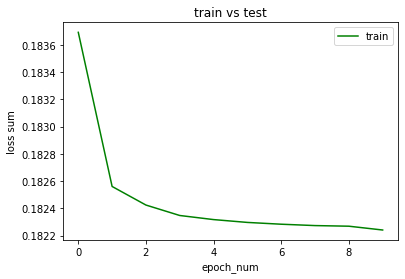

In [10]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import random
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from statistics import mean

batch_size = 100 # 250-500  # Number of samples in each batch to do(/9)
batch_size_test=750000  


epoch_num = 10  # Number of epochs to train the network
lr = 0.001        # Learning rate


#140000 - train
#60011 - test

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(13, 8)
        self.fc2 = nn.Linear(8, 3)
        self.fc3 = nn.Linear(3, 1)

    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        m = nn.Sigmoid()
        return m(x)

# class Model(nn.Module):
#     def __init__(self):
#         super(Model, self).__init__()
        
#         self.fc1 = nn.Linear(334, 290)
#         self.fc2 = nn.Linear(290, 210)
#         self.fc3 = nn.Linear(210, 170)
#         self.fc4 = nn.Linear(170, 130)
#         self.fc5 = nn.Linear(130, 90)
#         self.fc6 = nn.Linear(90, 10)
#         self.fc7 = nn.Linear(10, 1)


#         # # ...
#         # self.fc2 = nn.Linear(200, 100)


#         # self.fc3 = nn.Linear(100, 1) # conv1d??

#     def forward(self, x):
        
#         x = F.relu(self.fc1(x))  #leaky_relu ???
#         x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))  #leaky_relu ???
#         x = F.relu(self.fc4(x))
#         x = F.relu(self.fc5(x))  #leaky_relu ???
#         x = F.relu(self.fc6(x))
#         x = self.fc7(x)
#         m = nn.Sigmoid()
#         return m(x)
        

# class Model(nn.Module):
#     def __init__(self): 
#         super(Model, self).__init__()
#         self.classifier = nn.Sequential(
#             nn.Linear(334, 200),
#             nn.BatchNorm1d(200), #applying batch norm
#             nn.ReLU(),
#             nn.Linear(200, 100),
#             nn.BatchNorm1d(100),
#             nn.ReLU(),
#             nn.Linear(100, 1)
#         )
             
#     def forward(self, x):
#         x = x.view(x.size(0), -1)
#         x = self.classifier(x)
#         m = nn.Sigmoid()
#         return m(x)
#         # return x

model = Model()
alpha = 0.3

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)
# model.to(device)
# print(model)


# #convert to torch structure
# X_test_1_tensor = torch.FloatTensor(X_test_1) 
# X_test_0_tensor = torch.FloatTensor(X_test_0)


# #convert to torch structure
# treatment_test = treatment_test.to_numpy()
# treatment_test = torch.from_numpy(treatment_test).int()
# treatment_test = Variable(treatment_test)


# #convert to torch structure
# y_test = y_test.to_numpy()
# y_test = torch.from_numpy(y_test).float()
# y_test  = Variable(y_test)


# #convert to torch structure
# Z_trans_test = Z_trans_test.to_numpy()
# Z_trans_test = torch.from_numpy(Z_trans_test).float()
# Z_trans_test = Variable(Z_trans_test)


#init loaders
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size_test, shuffle=True)




# define the loss (criterion) and create an optimizer
optimizer = optim.Adam(model.parameters(),lr = lr)



# define lists of losses to store
all_losses  = []
test_losses = []
min_losses = []



# epochs loop
for ep in range(epoch_num):  
    model.train()
    print(".......................... epoch =",ep,"..........................")
    batch_loss = []
    # batches loop
    for X_batch_0,X_batch_1,Z_batch,treatment_batch, y_batch in train_loader:
       
       
        
        batch_1_feat = X_batch_1
        batch_0_feat = X_batch_0
        
        batch_label = y_batch
        batch_Z_trans = Z_batch

        optimizer.zero_grad()
        # Forward pass (predict)
        mu_1_target_class = model(batch_1_feat)
        mu_0_target_class = model(batch_0_feat)

        #convert to torch structure
        treatment_batch = treatment_batch
       

        mu_0_target_class = torch.reshape(mu_0_target_class, shape = (-1,))
        mu_1_target_class = torch.reshape(mu_1_target_class, shape =(-1,) )
        
        # print("mu_0", mu_0_target_class)
        # print("mu_1", mu_1_target_class)

        ones = np.ones(shape = batch_size)
        ones = torch.from_numpy(ones).float()
        

       
        #implements mu = T * mu_1 + (1-T) * mu_0
        uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 

        

        
       

       
        
        
        #declare losses
        loss_cross = nn.BCELoss(reduction = 'mean')
        loss_MSE = nn.MSELoss()

        #implements uplift_predicted = mu_1 - mu_0
        uplift_pred = mu_1_target_class - mu_0_target_class 
        
        
        # print("uplift_pred", uplift_pred)

        

        

        sum_of_losses = torch.mean(  (1-alpha) * loss_MSE(batch_Z_trans, uplift_pred) + alpha * loss_cross( uplift_pred_Y, batch_label))
        # print(loss_contrastive)
        batch_loss.append(sum_of_losses)
        # print("train AUQC:", qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))

        
        # print(batch_n, loss_contrastive)


        # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
        # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
        
        # Backward pass and updates
        sum_of_losses.backward()                     # calculate the gradients
        optimizer.step()                    # update the weights
        # i += batch_size
        #end for !!!!!!!!!!!!!!!!!!!

    # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
    # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
    batch_loss  = list(batch_loss)
    all_losses.append( sum(batch_loss) / len(batch_loss) ) 

    # #work with test dataset
    print('work with test dataset')
    batch_loss = []

   
    # model.eval()
    
    # for X_batch_0,X_batch_1,Z_batch,treatment_batch, y_batch in test_loader:
        
       
        
    #     batch_1_feat = X_batch_1
    #     batch_0_feat = X_batch_0
        
    #     batch_label = y_batch
    #     batch_Z_trans = Z_batch

    #     # optimizer.zero_grad()
    #     # Forward pass (predict)
    #     mu_1_target_class = model(batch_1_feat)
    #     mu_0_target_class = model(batch_0_feat)

       
       

    #     mu_0_target_class = torch.reshape(mu_0_target_class, shape = (-1,))
    #     mu_1_target_class = torch.reshape(mu_1_target_class, shape =(-1,) )
        
    #     # print("mu_0", mu_0_target_class)
    #     # print("mu_1", mu_1_target_class)

    #     ones = np.ones(shape = batch_size_test)
    #     ones = torch.from_numpy(ones).float()
        
     
    #     #implements mu = T * mu_1 + (1-T) * mu_0
    #     uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 

    #     #declare losses
    #     loss_cross = nn.BCELoss(reduction = 'mean')
    #     loss_MSE = nn.MSELoss()

    #     #implements uplift_predicted = mu_1 - mu_0
    #     uplift_pred = mu_1_target_class - mu_0_target_class   
        

    #     # scatter plot for mse parametres to do !!!
    #     sum_of_losses = torch.mean(  (1-alpha) * loss_MSE(batch_Z_trans, uplift_pred) + alpha * loss_cross( uplift_pred_Y, batch_label))
       
    #     batch_loss.append(sum_of_losses)
        

        
    #     # print(batch_n, loss_contrastive)


    #     # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
    #     # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
        
        
        
    # #     #end for
    # batch_loss  = list(batch_loss)
    # test_losses.append( sum(batch_loss) / len(batch_loss) ) 
    

    
   

import matplotlib.pyplot as plt

plt.plot(all_losses, color='green',label='train')
plt.title('train vs test')
plt.xlabel('epoch_num')
plt.ylabel('loss sum')



# plt.plot(test_losses, color='blue',label='test')
plt.legend()


plt.show()





In [11]:
from UPLIFT_modeling.uplift.metrics import Kendall_rank_correlation, qini_auc_score, uplift_at_k

all_res_uplift = []


for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = df_features.loc[indices_valid_new]
    treatment_valid = df_dataset.loc[indices_valid_new, 'treatment'].values
    target_valid = df_dataset.loc[indices_valid_new, 'visit'].values

    X_valid_0 = X_valid.copy()
    X_valid_1 = X_valid.copy()

    # X_valid_1 = X_valid_1.astype('float32')
    # X_valid_1 = X_valid_1.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_valid_1 = scaler.fit_transform(X_valid_1)

    # X_valid_0 = X_valid_0.astype('float32')
    # X_valid_0 = X_valid_0.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_valid_0 = scaler.fit_transform(X_valid_0)

    X_valid_0 = np.c_[ X_valid_0, np.zeros(X_valid_0.shape[0]) ]
    X_valid_1 = np.c_[ X_valid_1, np.ones(X_valid_1.shape[0]) ] 

    model.eval()
    X_valid_1 = torch.FloatTensor(X_valid_1)
    X_valid_0 = torch.FloatTensor(X_valid_0)
    
    mu_1 = model(X_valid_1)
    mu_0 = model(X_valid_0)
    valid_pred = mu_1-mu_0
    
    valid_pred = valid_pred.detach().numpy()
    valid_pred = valid_pred.reshape((-1,)) 
  
    valid_pred = pd.Series(valid_pred, index = indices_valid_new)
    
    # valid_pred = clf.predict(X_valid)

   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid, rate = 0.05)
 
    
    all_res_uplift.append(valid_scores)
   
    
print('Число замеров', j)

print('uplift5%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))


Число замеров 100
uplift5%: mean:  0.15393959636810722 | std:  0.006521763174348324


.......................... epoch = 0 ..........................
work with test dataset
.......................... epoch = 1 ..........................
work with test dataset
.......................... epoch = 2 ..........................
work with test dataset
.......................... epoch = 3 ..........................
work with test dataset
.......................... epoch = 4 ..........................
work with test dataset
.......................... epoch = 5 ..........................
work with test dataset
.......................... epoch = 6 ..........................
work with test dataset
.......................... epoch = 7 ..........................
work with test dataset
.......................... epoch = 8 ..........................
work with test dataset
.......................... epoch = 9 ..........................
work with test dataset
.......................... epoch = 10 ..........................
work with test dataset


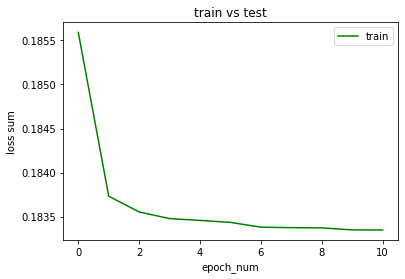

In [ ]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import random
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from statistics import mean

batch_size = 100 # 250-500  # Number of samples in each batch to do(/9)
batch_size_test=750000  


epoch_num = 11  # Number of epochs to train the network
lr = 0.001        # Learning rate


#140000 - train
#60011 - test

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(13, 8)
        self.fc2 = nn.Linear(8, 3)
        self.fc3 = nn.Linear(3, 1)

    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        m = nn.Sigmoid()
        return m(x)

# class Model(nn.Module):
#     def __init__(self):
#         super(Model, self).__init__()
        
#         self.fc1 = nn.Linear(334, 290)
#         self.fc2 = nn.Linear(290, 210)
#         self.fc3 = nn.Linear(210, 170)
#         self.fc4 = nn.Linear(170, 130)
#         self.fc5 = nn.Linear(130, 90)
#         self.fc6 = nn.Linear(90, 10)
#         self.fc7 = nn.Linear(10, 1)


#         # # ...
#         # self.fc2 = nn.Linear(200, 100)


#         # self.fc3 = nn.Linear(100, 1) # conv1d??

#     def forward(self, x):
        
#         x = F.relu(self.fc1(x))  #leaky_relu ???
#         x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))  #leaky_relu ???
#         x = F.relu(self.fc4(x))
#         x = F.relu(self.fc5(x))  #leaky_relu ???
#         x = F.relu(self.fc6(x))
#         x = self.fc7(x)
#         m = nn.Sigmoid()
#         return m(x)
        

# class Model(nn.Module):
#     def __init__(self): 
#         super(Model, self).__init__()
#         self.classifier = nn.Sequential(
#             nn.Linear(334, 200),
#             nn.BatchNorm1d(200), #applying batch norm
#             nn.ReLU(),
#             nn.Linear(200, 100),
#             nn.BatchNorm1d(100),
#             nn.ReLU(),
#             nn.Linear(100, 1)
#         )
             
#     def forward(self, x):
#         x = x.view(x.size(0), -1)
#         x = self.classifier(x)
#         m = nn.Sigmoid()
#         return m(x)
#         # return x

model = Model()
alpha = 0.3

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)
# model.to(device)
# print(model)


# #convert to torch structure
# X_test_1_tensor = torch.FloatTensor(X_test_1) 
# X_test_0_tensor = torch.FloatTensor(X_test_0)


# #convert to torch structure
# treatment_test = treatment_test.to_numpy()
# treatment_test = torch.from_numpy(treatment_test).int()
# treatment_test = Variable(treatment_test)


# #convert to torch structure
# y_test = y_test.to_numpy()
# y_test = torch.from_numpy(y_test).float()
# y_test  = Variable(y_test)


# #convert to torch structure
# Z_trans_test = Z_trans_test.to_numpy()
# Z_trans_test = torch.from_numpy(Z_trans_test).float()
# Z_trans_test = Variable(Z_trans_test)


#init loaders
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size_test, shuffle=True)




# define the loss (criterion) and create an optimizer
optimizer = optim.Adam(model.parameters(),lr = lr)



# define lists of losses to store
all_losses  = []
test_losses = []
min_losses = []



# epochs loop
for ep in range(epoch_num):  
    model.train()
    print(".......................... epoch =",ep,"..........................")
    batch_loss = []
    # batches loop
    for X_batch_0,X_batch_1,Z_batch,treatment_batch, y_batch in train_loader:
       
       
        
        batch_1_feat = X_batch_1
        batch_0_feat = X_batch_0
        
        batch_label = y_batch
        batch_Z_trans = Z_batch

        optimizer.zero_grad()
        # Forward pass (predict)
        mu_1_target_class = model(batch_1_feat)
        mu_0_target_class = model(batch_0_feat)

        #convert to torch structure
        treatment_batch = treatment_batch
       

        mu_0_target_class = torch.reshape(mu_0_target_class, shape = (-1,))
        mu_1_target_class = torch.reshape(mu_1_target_class, shape =(-1,) )
        
        # print("mu_0", mu_0_target_class)
        # print("mu_1", mu_1_target_class)

        ones = np.ones(shape = batch_size)
        ones = torch.from_numpy(ones).float()
        

       
        #implements mu = T * mu_1 + (1-T) * mu_0
        uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 

        

        
       

       
        
        
        #declare losses
        loss_cross = nn.BCELoss(reduction = 'mean')
        loss_MSE = nn.MSELoss()

        #implements uplift_predicted = mu_1 - mu_0
        uplift_pred = mu_1_target_class - mu_0_target_class 
        
        
        # print("uplift_pred", uplift_pred)

        

        

        sum_of_losses = torch.mean(  (1-alpha) * loss_MSE(batch_Z_trans, uplift_pred) + alpha * loss_cross( uplift_pred_Y, batch_label))
        # print(loss_contrastive)
        batch_loss.append(sum_of_losses)
        # print("train AUQC:", qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))

        
        # print(batch_n, loss_contrastive)


        # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
        # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
        
        # Backward pass and updates
        sum_of_losses.backward()                     # calculate the gradients
        optimizer.step()                    # update the weights
        # i += batch_size
        #end for !!!!!!!!!!!!!!!!!!!

    # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
    # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
    batch_loss  = list(batch_loss)
    all_losses.append( sum(batch_loss) / len(batch_loss) ) 

    # #work with test dataset
    print('work with test dataset')
    batch_loss = []

   
    # model.eval()
    
    # for X_batch_0,X_batch_1,Z_batch,treatment_batch, y_batch in test_loader:
        
       
        
    #     batch_1_feat = X_batch_1
    #     batch_0_feat = X_batch_0
        
    #     batch_label = y_batch
    #     batch_Z_trans = Z_batch

    #     # optimizer.zero_grad()
    #     # Forward pass (predict)
    #     mu_1_target_class = model(batch_1_feat)
    #     mu_0_target_class = model(batch_0_feat)

       
       

    #     mu_0_target_class = torch.reshape(mu_0_target_class, shape = (-1,))
    #     mu_1_target_class = torch.reshape(mu_1_target_class, shape =(-1,) )
        
    #     # print("mu_0", mu_0_target_class)
    #     # print("mu_1", mu_1_target_class)

    #     ones = np.ones(shape = batch_size_test)
    #     ones = torch.from_numpy(ones).float()
        
     
    #     #implements mu = T * mu_1 + (1-T) * mu_0
    #     uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 

    #     #declare losses
    #     loss_cross = nn.BCELoss(reduction = 'mean')
    #     loss_MSE = nn.MSELoss()

    #     #implements uplift_predicted = mu_1 - mu_0
    #     uplift_pred = mu_1_target_class - mu_0_target_class   
        

    #     # scatter plot for mse parametres to do !!!
    #     sum_of_losses = torch.mean(  (1-alpha) * loss_MSE(batch_Z_trans, uplift_pred) + alpha * loss_cross( uplift_pred_Y, batch_label))
       
    #     batch_loss.append(sum_of_losses)
        

        
    #     # print(batch_n, loss_contrastive)


    #     # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
    #     # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
        
        
        
    # #     #end for
    # batch_loss  = list(batch_loss)
    # test_losses.append( sum(batch_loss) / len(batch_loss) ) 
    

    
   

import matplotlib.pyplot as plt

plt.plot(all_losses, color='green',label='train')
plt.title('train vs test')
plt.xlabel('epoch_num')
plt.ylabel('loss sum')



# plt.plot(test_losses, color='blue',label='test')
plt.legend()


plt.show()





In [ ]:
from UPLIFT_modeling.uplift.metrics import Kendall_rank_correlation, qini_auc_score, uplift_at_k

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = df_features.loc[indices_valid_new]
    treatment_valid = df_dataset.loc[indices_valid_new, 'treatment'].values
    target_valid = df_dataset.loc[indices_valid_new, 'visit'].values

    X_valid_0 = X_valid.copy()
    X_valid_1 = X_valid.copy()

    # X_valid_1 = X_valid_1.astype('float32')
    # X_valid_1 = X_valid_1.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_valid_1 = scaler.fit_transform(X_valid_1)

    # X_valid_0 = X_valid_0.astype('float32')
    # X_valid_0 = X_valid_0.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_valid_0 = scaler.fit_transform(X_valid_0)

    X_valid_0 = np.c_[ X_valid_0, np.zeros(X_valid_0.shape[0]) ]
    X_valid_1 = np.c_[ X_valid_1, np.ones(X_valid_1.shape[0]) ] 

    model.eval()
    X_valid_1 = torch.FloatTensor(X_valid_1)
    X_valid_0 = torch.FloatTensor(X_valid_0)
    
    mu_1 = model(X_valid_1)
    mu_0 = model(X_valid_0)
    valid_pred = mu_1-mu_0
    
    valid_pred = valid_pred.detach().numpy()
    valid_pred = valid_pred.reshape((-1,)) 
  
    valid_pred = pd.Series(valid_pred, index = indices_valid_new)
    
    # valid_pred = clf.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.9999999999999999 with p_value =  5.511463844797178e-07
Kendal uplift rank correlation =  0.8666666666666666 with p_value =  0.00011518959435626102
Kendal uplift rank correlation =  0.9555555555555554 with p_value =  5.5114638447971785e-06
Kendal uplift rank correlation =  0.9999999999999999 with p_value =  5.511463844797178e-07
Kendal uplift rank correlation =  0.8222222222222221 with p_value =  0.0003576940035273369
Kendal uplift rank correlation =  0.8666666666666666 with p_value =  0.00011518959435626102
Kendal uplift rank correlation =  0.8222222222222221 with p_value =  0.0003576940035273369
Kendal uplift rank correlation =  0.911111111111111 with p_value =  2.9761904761904762e-05
Kendal uplift rank correlation =  0.8666666666666666 with p_value =  0.00011518959435626102
Kendal uplift rank correlation =  0.8666666666666666 with p_value =  0.00011518959435626102
Kendal uplift rank correlation =  0.911111111111111 with p_value =  2.976190476190476

In [ ]:
plt.style.use('seaborn-dark')
plt.rc('font', size=17)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


AttributeError: ignored

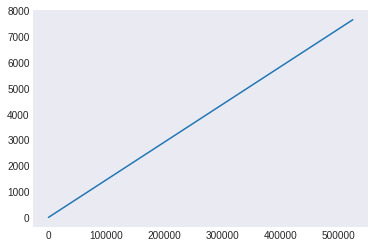

In [ ]:
from UPLIFT_modeling.uplift.metrics import  qini_curve,perfect_qini_curve
import matplotlib.pyplot as plt
x,y =qini_curve(target_valid, valid_pred, treatment_valid)
x_best, y_best = perfect_qini_curve(target_valid, treatment_valid)
a = plt.plot([ x[0], x[len(x)-1] ], [ y[0], y[len(y) - 1  ]] )

plt.plot(x,y,linewidth=5)
plt.grid()
plt.fill_between(x,y,a)
plt.xlabel('Targeted objects')
plt.ylabel('Uplift reactions')
plt.title('Qini кривая')

plt.plot(x_best,y_best,linewidth=2, markersize=12)

.......................... epoch = 0 ..........................
work with test dataset
.......................... epoch = 1 ..........................
work with test dataset
.......................... epoch = 2 ..........................
work with test dataset
.......................... epoch = 3 ..........................
work with test dataset
.......................... epoch = 4 ..........................
work with test dataset
.......................... epoch = 5 ..........................
work with test dataset
.......................... epoch = 6 ..........................
work with test dataset
.......................... epoch = 7 ..........................
work with test dataset
.......................... epoch = 8 ..........................
work with test dataset
.......................... epoch = 9 ..........................
work with test dataset


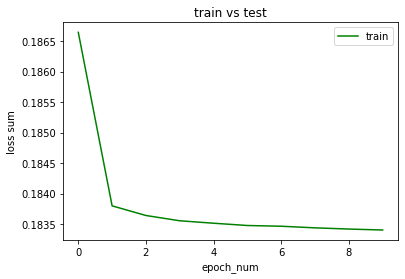

In [ ]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import random
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from statistics import mean

batch_size = 100 # 250-500  # Number of samples in each batch to do(/9)
batch_size_test=750000  


epoch_num = 10  # Number of epochs to train the network
lr = 0.001        # Learning rate


#140000 - train
#60011 - test

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(13, 8)
        self.fc2 = nn.Linear(8, 3)
        self.fc3 = nn.Linear(3, 1)

    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        m = nn.Sigmoid()
        return m(x)

# class Model(nn.Module):
#     def __init__(self):
#         super(Model, self).__init__()
        
#         self.fc1 = nn.Linear(334, 290)
#         self.fc2 = nn.Linear(290, 210)
#         self.fc3 = nn.Linear(210, 170)
#         self.fc4 = nn.Linear(170, 130)
#         self.fc5 = nn.Linear(130, 90)
#         self.fc6 = nn.Linear(90, 10)
#         self.fc7 = nn.Linear(10, 1)


#         # # ...
#         # self.fc2 = nn.Linear(200, 100)


#         # self.fc3 = nn.Linear(100, 1) # conv1d??

#     def forward(self, x):
        
#         x = F.relu(self.fc1(x))  #leaky_relu ???
#         x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))  #leaky_relu ???
#         x = F.relu(self.fc4(x))
#         x = F.relu(self.fc5(x))  #leaky_relu ???
#         x = F.relu(self.fc6(x))
#         x = self.fc7(x)
#         m = nn.Sigmoid()
#         return m(x)
        

# class Model(nn.Module):
#     def __init__(self): 
#         super(Model, self).__init__()
#         self.classifier = nn.Sequential(
#             nn.Linear(334, 200),
#             nn.BatchNorm1d(200), #applying batch norm
#             nn.ReLU(),
#             nn.Linear(200, 100),
#             nn.BatchNorm1d(100),
#             nn.ReLU(),
#             nn.Linear(100, 1)
#         )
             
#     def forward(self, x):
#         x = x.view(x.size(0), -1)
#         x = self.classifier(x)
#         m = nn.Sigmoid()
#         return m(x)
#         # return x

model = Model()
alpha = 0.3

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)
# model.to(device)
# print(model)


# #convert to torch structure
# X_test_1_tensor = torch.FloatTensor(X_test_1) 
# X_test_0_tensor = torch.FloatTensor(X_test_0)


# #convert to torch structure
# treatment_test = treatment_test.to_numpy()
# treatment_test = torch.from_numpy(treatment_test).int()
# treatment_test = Variable(treatment_test)


# #convert to torch structure
# y_test = y_test.to_numpy()
# y_test = torch.from_numpy(y_test).float()
# y_test  = Variable(y_test)


# #convert to torch structure
# Z_trans_test = Z_trans_test.to_numpy()
# Z_trans_test = torch.from_numpy(Z_trans_test).float()
# Z_trans_test = Variable(Z_trans_test)


#init loaders
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size_test, shuffle=True)




# define the loss (criterion) and create an optimizer
optimizer = optim.Adam(model.parameters(),lr = lr)



# define lists of losses to store
all_losses  = []
test_losses = []
min_losses = []



# epochs loop
for ep in range(epoch_num):  
    model.train()
    print(".......................... epoch =",ep,"..........................")
    batch_loss = []
    # batches loop
    for X_batch_0,X_batch_1,Z_batch,treatment_batch, y_batch in train_loader:
       
       
        
        batch_1_feat = X_batch_1
        batch_0_feat = X_batch_0
        
        batch_label = y_batch
        batch_Z_trans = Z_batch

        optimizer.zero_grad()
        # Forward pass (predict)
        mu_1_target_class = model(batch_1_feat)
        mu_0_target_class = model(batch_0_feat)

        #convert to torch structure
        treatment_batch = treatment_batch
       

        mu_0_target_class = torch.reshape(mu_0_target_class, shape = (-1,))
        mu_1_target_class = torch.reshape(mu_1_target_class, shape =(-1,) )
        
        # print("mu_0", mu_0_target_class)
        # print("mu_1", mu_1_target_class)

        ones = np.ones(shape = batch_size)
        ones = torch.from_numpy(ones).float()
        

       
        #implements mu = T * mu_1 + (1-T) * mu_0
        uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 

        

        
       

       
        
        
        #declare losses
        loss_cross = nn.BCELoss(reduction = 'mean')
        loss_MSE = nn.MSELoss()

        #implements uplift_predicted = mu_1 - mu_0
        uplift_pred = mu_1_target_class - mu_0_target_class 
        
        
        # print("uplift_pred", uplift_pred)

        

        

        sum_of_losses = torch.mean(  (1-alpha) * loss_MSE(batch_Z_trans, uplift_pred) + alpha * loss_cross( uplift_pred_Y, batch_label))
        # print(loss_contrastive)
        batch_loss.append(sum_of_losses)
        # print("train AUQC:", qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))

        
        # print(batch_n, loss_contrastive)


        # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
        # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
        
        # Backward pass and updates
        sum_of_losses.backward()                     # calculate the gradients
        optimizer.step()                    # update the weights
        # i += batch_size
        #end for !!!!!!!!!!!!!!!!!!!

    # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
    # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
    batch_loss  = list(batch_loss)
    all_losses.append( sum(batch_loss) / len(batch_loss) ) 

    # #work with test dataset
    print('work with test dataset')
    batch_loss = []

   
    # model.eval()
    
    # for X_batch_0,X_batch_1,Z_batch,treatment_batch, y_batch in test_loader:
        
       
        
    #     batch_1_feat = X_batch_1
    #     batch_0_feat = X_batch_0
        
    #     batch_label = y_batch
    #     batch_Z_trans = Z_batch

    #     # optimizer.zero_grad()
    #     # Forward pass (predict)
    #     mu_1_target_class = model(batch_1_feat)
    #     mu_0_target_class = model(batch_0_feat)

       
       

    #     mu_0_target_class = torch.reshape(mu_0_target_class, shape = (-1,))
    #     mu_1_target_class = torch.reshape(mu_1_target_class, shape =(-1,) )
        
    #     # print("mu_0", mu_0_target_class)
    #     # print("mu_1", mu_1_target_class)

    #     ones = np.ones(shape = batch_size_test)
    #     ones = torch.from_numpy(ones).float()
        
     
    #     #implements mu = T * mu_1 + (1-T) * mu_0
    #     uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 

    #     #declare losses
    #     loss_cross = nn.BCELoss(reduction = 'mean')
    #     loss_MSE = nn.MSELoss()

    #     #implements uplift_predicted = mu_1 - mu_0
    #     uplift_pred = mu_1_target_class - mu_0_target_class   
        

    #     # scatter plot for mse parametres to do !!!
    #     sum_of_losses = torch.mean(  (1-alpha) * loss_MSE(batch_Z_trans, uplift_pred) + alpha * loss_cross( uplift_pred_Y, batch_label))
       
    #     batch_loss.append(sum_of_losses)
        

        
    #     # print(batch_n, loss_contrastive)


    #     # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
    #     # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
        
        
        
    # #     #end for
    # batch_loss  = list(batch_loss)
    # test_losses.append( sum(batch_loss) / len(batch_loss) ) 
    

    
   

import matplotlib.pyplot as plt

plt.plot(all_losses, color='green',label='train')
plt.title('train vs test')
plt.xlabel('epoch_num')
plt.ylabel('loss sum')



# plt.plot(test_losses, color='blue',label='test')
plt.legend()


plt.show()





In [ ]:
from UPLIFT_modeling.uplift.metrics import Kendall_rank_correlation, qini_auc_score, uplift_at_k

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = df_features.loc[indices_valid_new]
    treatment_valid = df_dataset.loc[indices_valid_new, 'treatment'].values
    target_valid = df_dataset.loc[indices_valid_new, 'visit'].values

    X_valid_0 = X_valid.copy()
    X_valid_1 = X_valid.copy()

    # X_valid_1 = X_valid_1.astype('float32')
    # X_valid_1 = X_valid_1.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_valid_1 = scaler.fit_transform(X_valid_1)

    # X_valid_0 = X_valid_0.astype('float32')
    # X_valid_0 = X_valid_0.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_valid_0 = scaler.fit_transform(X_valid_0)

    X_valid_0 = np.c_[ X_valid_0, np.zeros(X_valid_0.shape[0]) ]
    X_valid_1 = np.c_[ X_valid_1, np.ones(X_valid_1.shape[0]) ] 

    model.eval()
    X_valid_1 = torch.FloatTensor(X_valid_1)
    X_valid_0 = torch.FloatTensor(X_valid_0)
    
    mu_1 = model(X_valid_1)
    mu_0 = model(X_valid_0)
    valid_pred = mu_1-mu_0
    
    valid_pred = valid_pred.detach().numpy()
    valid_pred = valid_pred.reshape((-1,)) 
  
    valid_pred = pd.Series(valid_pred, index = indices_valid_new)
    
    # valid_pred = clf.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.8989331499509895 with p_value =  0.0003280163150135285
Kendal uplift rank correlation =  0.9888264649460884 with p_value =  7.772240795323109e-05
Kendal uplift rank correlation =  0.8989331499509895 with p_value =  0.0003280163150135285
Kendal uplift rank correlation =  0.8090398349558905 with p_value =  0.0012254240706707125
Kendal uplift rank correlation =  0.8539864924534399 with p_value =  0.0006436975254696877
Kendal uplift rank correlation =  0.8989331499509895 with p_value =  0.0003280163150135285
Kendal uplift rank correlation =  0.8539864924534399 with p_value =  0.0006436975254696877
Kendal uplift rank correlation =  0.8666666666666666 with p_value =  0.00011518959435626102
Kendal uplift rank correlation =  0.764093177458341 with p_value =  0.002263469812035179
Kendal uplift rank correlation =  0.9438798074485389 with p_value =  0.00016213175204392636
Kendal uplift rank correlation =  0.8539864924534399 with p_value =  0.0006436975254696877

# Предыдущие эксперименты(вкладка округление google sheets)

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 

N_ROWS = 5000000 #number of samples

df_dataset = pd.read_csv("criteo-uplift.csv", nrows = N_ROWS)

df_dataset = reduce_mem_usage(df_dataset)


df_features = pd.DataFrame({
    'f0': df_dataset['f0'],
    'f1': df_dataset['f1'],
    'f2': df_dataset['f2'],
    'f3': df_dataset['f3'],
    'f4': df_dataset['f4'],
    'f5': df_dataset['f5'],
    'f6': df_dataset['f6'],
    'f7': df_dataset['f7'],
    'f8': df_dataset['f8'],
    'f9': df_dataset['f9'],
    'f10': df_dataset['f10'],
    'f11': df_dataset['f11'],
},index = df_dataset.index)
#fit on 
indices_all =  [i for i in range(df_dataset.shape[0])]

p = 0.8462388

df_dataset['Z_trans'] = df_dataset['visit']* ( (df_dataset['treatment'] - p) / ( p*(1-p) ) )

indices_train, indices_test = train_test_split(indices_all,test_size = 0.3)
indices_test, indices_eval = train_test_split(indices_test, test_size = 0.5)

X_train = df_features.loc[indices_train]
treatment_train = df_dataset.loc[indices_train,'treatment'].values
Y_train_visit = df_dataset.loc[indices_train,'visit'].values

X_test = df_features.loc[indices_test]
Y_test_visit =  df_dataset.loc[indices_test,'visit'].values
treatment_test = df_dataset.loc[indices_test,'treatment'].values

X_eval = df_features.loc[indices_eval].values
Y_eval_visit =  df_dataset.loc[indices_eval,'visit'].values
treatment_eval = df_dataset.loc[indices_eval,'treatment'].values

 



all = df_dataset.copy()
train =all.loc[indices_train,]
test = all.loc[indices_test,]


Z_trans_train = train['Z_trans']
Z_trans_train = Z_trans_train.to_numpy()

Z_trans_test = test['Z_trans']
Z_trans_test = Z_trans_test.to_numpy()

Mem. usage decreased to 133.51 Mb (78.1% reduction)


In [ ]:
print(df_dataset[['treatment','visit','Z_trans']])

         treatment  visit  Z_trans
0                1      0   0.0000
1                1      0   0.0000
2                1      0   0.0000
3                1      0   0.0000
4                0      0  -0.0000
...            ...    ...      ...
4999995          1      0   0.0000
4999996          1      0   0.0000
4999997          1      0   0.0000
4999998          1      1   1.1817
4999999          1      0   0.0000

[5000000 rows x 3 columns]


In [ ]:
# all = df_dataset.copy()
# train =all.loc[indices_train,]
# test = all.loc[indices_test,]


# treatment_train = train['treatment']
# treatment_train = treatment_train.to_numpy()

# y_train = train['visit']
# y_train = y_train.to_numpy()

# Z_trans_train = train['Z_trans']
# Z_trans_train = Z_trans_train.to_numpy()

# treatment_test = test['treatment']
# treatment_test = treatment_test.to_numpy()

# y_test = test['visit']
# y_test = y_test.to_numpy()

# Z_trans_test = test['Z_trans']
# Z_trans_test = Z_trans_test.to_numpy()


# train=train.drop('Z_trans',axis = 1)
# train=train.drop('visit',axis = 1)
# train=train.drop('treatment',axis = 1)

# test=test.drop('Z_trans',axis = 1)
# test=test.drop('visit',axis = 1)
# test=test.drop('treatment',axis = 1)

In [ ]:
print("propensity score in train:", treatment_train[treatment_train == 1].shape[0] / treatment_train.shape[0])
print("propensity score in test:", treatment_test[treatment_test == 1].shape[0] / treatment_test.shape[0])
print("------------------------------------")
print("reaction rate in train:", visit_train[visit_train == 1].shape[0] / visit_train.shape[0])
print("reaction rate in test:", Y_test_visit[Y_test_visit == 1].shape[0] / Y_test_visit.shape[0])



propensity score in train: 0.8462388
propensity score in test: 0.8458764
------------------------------------
reaction rate in train: 0.0413584
reaction rate in test: 0.041282


In [ ]:
from sklearn.preprocessing import StandardScaler 
import numpy as np


scaler = StandardScaler(with_std = True, with_mean = True)

X_train_0 = X_train.copy()
# X_train_0['treatment'] = 0

X_train_1 = X_train.copy()
# X_train_1['treatment'] = 1

X_train_1 = X_train_1.astype('float32')
X_train_1 = X_train_1.replace([np.inf, -np.inf], np.nan).fillna(0)
X_train_1 = scaler.fit_transform(X_train_1)



X_train_0 = X_train_0.astype('float32')
X_train_0 = X_train_0.replace([np.inf, -np.inf], np.nan).fillna(0)
X_train_0 = scaler.fit_transform(X_train_0)


X_test_0 = X_test.copy()
# X_test_0['treatment'] = 0

X_test_1 = X_test.copy()
# X_test_1['treatment'] = 1

X_test_1 = X_test_1.astype('float32')
# X_test_1 = X_test_1.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test_1 = scaler.fit_transform(X_test_1)

X_test_0 = X_test_0.astype('float32')
# X_test_0 = X_test_0.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test_0 = scaler.fit_transform(X_test_0)

X_test_0 = np.c_[ X_test_0, np.zeros(X_test_0.shape[0]) ]
X_test_1 = np.c_[ X_test_1, np.ones(X_test_1.shape[0]) ] 

X_train_0 = np.c_[ X_train_0, np.zeros(X_train_0.shape[0]) ]
X_train_1 = np.c_[ X_train_1, np.ones(X_train_1.shape[0]) ]

# X_train_0 = np.c_[ X_train_0, treatment_train ]
# X_train_1 = np.c_[ X_train_1, treatment_train ]

# X_train_0 = np.c_[ X_train_0, y_train ]
# X_train_1 = np.c_[ X_train_1, y_train ]

# X_train_0 = np.c_[ X_train_0, Z_trans_train ]
# X_train_1 = np.c_[ X_train_1, Z_trans_train ]






print(X_train_0, "size = ", type(X_train_0))
print(X_train_1, "size = ", X_train_1.shape)

print(X_test_0, "size = ", X_test_0.shape)
print(X_test_1, "size = ", X_test_1.shape)


# np.savetxt('train_0.txt', X_train_0, delimiter=',')
# np.savetxt('train_1.txt', X_train_1, delimiter=',')

[[ 0.89418066 -0.0880317   0.19703905 ...  0.16729136 -0.08557208
   0.        ]
 [ 0.89418066 -0.0880317  -0.39138862 ...  0.16729136 -0.08557208
   0.        ]
 [-0.87942213 -0.0880317  -0.65291202 ...  0.16729136 -0.08557208
   0.        ]
 ...
 [ 0.89418066 -0.0880317   0.80726033 ...  0.16729136 -0.08557208
   0.        ]
 [-0.20465773 -0.0880317  -0.65291202 ...  0.16729136 -0.08557208
   0.        ]
 [-1.57772851 -0.0880317  -0.65291202 ...  0.16729136 -0.08557208
   0.        ]] size =  <class 'numpy.ndarray'>
[[ 0.89418066 -0.0880317   0.19703905 ...  0.16729136 -0.08557208
   1.        ]
 [ 0.89418066 -0.0880317  -0.39138862 ...  0.16729136 -0.08557208
   1.        ]
 [-0.87942213 -0.0880317  -0.65291202 ...  0.16729136 -0.08557208
   1.        ]
 ...
 [ 0.89418066 -0.0880317   0.80726033 ...  0.16729136 -0.08557208
   1.        ]
 [-0.20465773 -0.0880317  -0.65291202 ...  0.16729136 -0.08557208
   1.        ]
 [-1.57772851 -0.0880317  -0.65291202 ...  0.16729136 -0.08557208


In [ ]:
!7z a -tzip -mx5 -r0 /content/archive.zip train_0.txt train_1.txt


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive:
  0M Scan           
train_0.txt


train_1.txt

0 files, 0 bytes

Creating archive: /content/archive.zip

Items to compress: 0

  0%    
Files read from disk: 0
Archive size: 22 bytes (1 KiB)

Scan WARNINGS for files and folders:

train_0.txt : No more files
train_1.txt : No more files
----------------
Scan WARNINGS: 2


In [ ]:
class trainData(Dataset):
    
    def __init__(self, X_data_0,X_data_1,Z_trans,treatment, y_data):
        self.X_data_0 = X_data_0
        self.X_data_1 = X_data_1
        self.Z_trans = Z_trans
        self.treatment = treatment
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data_0[index], self.X_data_1[index],self.Z_trans[index], self.treatment[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data_0)


train_data = trainData(torch.FloatTensor(X_train_0),torch.FloatTensor(X_train_1),torch.FloatTensor(Z_trans_train),torch.FloatTensor(treatment_train), 
                       torch.FloatTensor(Y_train_visit))
## test data    

class testData(Dataset):
    
    def __init__(self, X_data_0,X_data_1,Z_trans,treatment,y_data):
        self.X_data_0 = X_data_0
        self.X_data_1 = X_data_1
        self.Z_trans = Z_trans
        self.treatment = treatment
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data_0[index], self.X_data_1[index],self.Z_trans[index], self.treatment[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data_0)
    

test_data = testData(torch.FloatTensor(X_test_0),torch.FloatTensor(X_test_1), torch.FloatTensor(Z_trans_test),torch.FloatTensor(treatment_test), 
                       torch.FloatTensor(Y_test_visit))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pylab

  
from sklearn.utils.validation import check_consistent_length



def plot_qini_curve(y_reactions, uplift_score, treatment, random=True, perfect=True):
    """Plot Qini curves from predictions."""
   
    check_consistent_length(y_reactions, uplift_score, treatment)
    y_reactions, uplift_score, treatment = np.array(y_reactions), np.array(uplift_score), np.array(treatment)

   

    x_actual, y_actual = qini_curve(y_reactions, uplift_score, treatment)

    pylab.plot(x_actual, y_actual, label='Our model', color='green')
    if random:
        x_baseline, y_baseline = x_actual, x_actual * y_actual[-1] / len(y_reactions)
        pylab.plot(x_baseline, y_baseline, label='Random model', color='black')
        

    if perfect:
        x_perfect, y_perfect = perfect_qini_curve(y_reactions, treatment)
        # print("1 point", x_perfect[1], y_perfect[1])
        # print("2 point", x_perfect[2], y_perfect[2])
        # print("3 point", x_perfect[3], y_perfect[3])
        pylab.plot(x_perfect, y_perfect, label='Perfect model', color='Red')
        
    #pylab.fill_between(x_perfect, y_baseline, y_perfect, color="blue")
    pylab.grid(True)
    pylab.xlabel('Treat num')
    pylab.ylabel('Uplift reactions')
    pylab.title('Qini curve')
    pylab.legend(loc='lower right')
    return pylab




рисуем на трейне и на тесте


.......................... epoch = 0 ..........................
work with test dataset
.......................... epoch = 1 ..........................
work with test dataset
.......................... epoch = 2 ..........................
work with test dataset
.......................... epoch = 3 ..........................
work with test dataset
.......................... epoch = 4 ..........................
work with test dataset
.......................... epoch = 5 ..........................
work with test dataset
.......................... epoch = 6 ..........................
work with test dataset


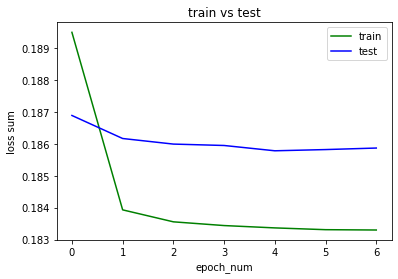

In [ ]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import random
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from statistics import mean

batch_size = 100 # 250-500  # Number of samples in each batch to do(/9)
batch_size_test=750000  


epoch_num = 7  # Number of epochs to train the network
lr = 0.001        # Learning rate


#140000 - train
#60011 - test

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(13, 8)
        self.fc2 = nn.Linear(8, 3)
        self.fc3 = nn.Linear(3, 1)

    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        m = nn.Sigmoid()
        return m(x)

# class Model(nn.Module):
#     def __init__(self):
#         super(Model, self).__init__()
        
#         self.fc1 = nn.Linear(334, 290)
#         self.fc2 = nn.Linear(290, 210)
#         self.fc3 = nn.Linear(210, 170)
#         self.fc4 = nn.Linear(170, 130)
#         self.fc5 = nn.Linear(130, 90)
#         self.fc6 = nn.Linear(90, 10)
#         self.fc7 = nn.Linear(10, 1)


#         # # ...
#         # self.fc2 = nn.Linear(200, 100)


#         # self.fc3 = nn.Linear(100, 1) # conv1d??

#     def forward(self, x):
        
#         x = F.relu(self.fc1(x))  #leaky_relu ???
#         x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))  #leaky_relu ???
#         x = F.relu(self.fc4(x))
#         x = F.relu(self.fc5(x))  #leaky_relu ???
#         x = F.relu(self.fc6(x))
#         x = self.fc7(x)
#         m = nn.Sigmoid()
#         return m(x)
        

# class Model(nn.Module):
#     def __init__(self): 
#         super(Model, self).__init__()
#         self.classifier = nn.Sequential(
#             nn.Linear(334, 200),
#             nn.BatchNorm1d(200), #applying batch norm
#             nn.ReLU(),
#             nn.Linear(200, 100),
#             nn.BatchNorm1d(100),
#             nn.ReLU(),
#             nn.Linear(100, 1)
#         )
             
#     def forward(self, x):
#         x = x.view(x.size(0), -1)
#         x = self.classifier(x)
#         m = nn.Sigmoid()
#         return m(x)
#         # return x

model = Model()
alpha = 0.3

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)
# model.to(device)
# print(model)


# #convert to torch structure
# X_test_1_tensor = torch.FloatTensor(X_test_1) 
# X_test_0_tensor = torch.FloatTensor(X_test_0)


# #convert to torch structure
# treatment_test = treatment_test.to_numpy()
# treatment_test = torch.from_numpy(treatment_test).int()
# treatment_test = Variable(treatment_test)


# #convert to torch structure
# y_test = y_test.to_numpy()
# y_test = torch.from_numpy(y_test).float()
# y_test  = Variable(y_test)


# #convert to torch structure
# Z_trans_test = Z_trans_test.to_numpy()
# Z_trans_test = torch.from_numpy(Z_trans_test).float()
# Z_trans_test = Variable(Z_trans_test)


#init loaders
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size_test, shuffle=True)




# define the loss (criterion) and create an optimizer
optimizer = optim.Adam(model.parameters(),lr = lr)



# define lists of losses to store
all_losses  = []
test_losses = []
min_losses = []



# epochs loop
for ep in range(epoch_num):  
    model.train()
    print(".......................... epoch =",ep,"..........................")
    batch_loss = []
    # batches loop
    for X_batch_0,X_batch_1,Z_batch,treatment_batch, y_batch in train_loader:
       
       
        
        batch_1_feat = X_batch_1
        batch_0_feat = X_batch_0
        
        batch_label = y_batch
        batch_Z_trans = Z_batch

        optimizer.zero_grad()
        # Forward pass (predict)
        mu_1_target_class = model(batch_1_feat)
        mu_0_target_class = model(batch_0_feat)

        #convert to torch structure
        treatment_batch = treatment_batch
       

        mu_0_target_class = torch.reshape(mu_0_target_class, shape = (-1,))
        mu_1_target_class = torch.reshape(mu_1_target_class, shape =(-1,) )
        
        # print("mu_0", mu_0_target_class)
        # print("mu_1", mu_1_target_class)

        ones = np.ones(shape = batch_size)
        ones = torch.from_numpy(ones).float()
        

       
        #implements mu = T * mu_1 + (1-T) * mu_0
        uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 

        

        
       

       
        
        
        #declare losses
        loss_cross = nn.BCELoss(reduction = 'mean')
        loss_MSE = nn.MSELoss()

        #implements uplift_predicted = mu_1 - mu_0
        uplift_pred = mu_1_target_class - mu_0_target_class 
        
        
        # print("uplift_pred", uplift_pred)

        

        

        sum_of_losses = torch.mean(  (1-alpha) * loss_MSE(batch_Z_trans, uplift_pred) + alpha * loss_cross( uplift_pred_Y, batch_label))
        # print(loss_contrastive)
        batch_loss.append(sum_of_losses)
        # print("train AUQC:", qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))

        
        # print(batch_n, loss_contrastive)


        # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
        # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
        
        # Backward pass and updates
        sum_of_losses.backward()                     # calculate the gradients
        optimizer.step()                    # update the weights
        # i += batch_size
        #end for !!!!!!!!!!!!!!!!!!!

    # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
    # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
    batch_loss  = list(batch_loss)
    all_losses.append( sum(batch_loss) / len(batch_loss) ) 

    # #work with test dataset
    print('work with test dataset')
    batch_loss = []

   
    model.eval()
    
    for X_batch_0,X_batch_1,Z_batch,treatment_batch, y_batch in test_loader:
        
       
        
        batch_1_feat = X_batch_1
        batch_0_feat = X_batch_0
        
        batch_label = y_batch
        batch_Z_trans = Z_batch

        # optimizer.zero_grad()
        # Forward pass (predict)
        mu_1_target_class = model(batch_1_feat)
        mu_0_target_class = model(batch_0_feat)

       
       

        mu_0_target_class = torch.reshape(mu_0_target_class, shape = (-1,))
        mu_1_target_class = torch.reshape(mu_1_target_class, shape =(-1,) )
        
        # print("mu_0", mu_0_target_class)
        # print("mu_1", mu_1_target_class)

        ones = np.ones(shape = batch_size_test)
        ones = torch.from_numpy(ones).float()
        
     
        #implements mu = T * mu_1 + (1-T) * mu_0
        uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 

        #declare losses
        loss_cross = nn.BCELoss(reduction = 'mean')
        loss_MSE = nn.MSELoss()

        #implements uplift_predicted = mu_1 - mu_0
        uplift_pred = mu_1_target_class - mu_0_target_class   
        

        # scatter plot for mse parametres to do !!!
        sum_of_losses = torch.mean(  (1-alpha) * loss_MSE(batch_Z_trans, uplift_pred) + alpha * loss_cross( uplift_pred_Y, batch_label))
       
        batch_loss.append(sum_of_losses)
        

        
        # print(batch_n, loss_contrastive)


        # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
        # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
        
        
        
    #     #end for
    batch_loss  = list(batch_loss)
    test_losses.append( sum(batch_loss) / len(batch_loss) ) 
    

    
   

import matplotlib.pyplot as plt

plt.plot(all_losses, color='green',label='train')
plt.title('train vs test')
plt.xlabel('epoch_num')
plt.ylabel('loss sum')



plt.plot(test_losses, color='blue',label='test')
plt.legend()


plt.show()





neural network with dataloader (то, что работает ) 

.......................... epoch = 0 ..........................
work with test dataset
.......................... epoch = 1 ..........................
work with test dataset
.......................... epoch = 2 ..........................
work with test dataset
.......................... epoch = 3 ..........................
work with test dataset
.......................... epoch = 4 ..........................
work with test dataset
.......................... epoch = 5 ..........................
work with test dataset
.......................... epoch = 6 ..........................
work with test dataset
.......................... epoch = 7 ..........................
work with test dataset
.......................... epoch = 8 ..........................
work with test dataset
.......................... epoch = 9 ..........................
work with test dataset


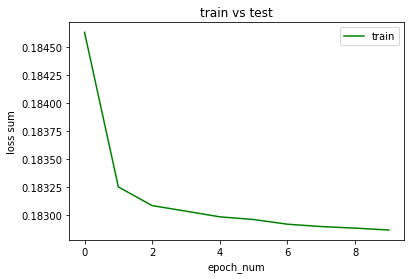

In [ ]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import random
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from statistics import mean

batch_size = 100 # 250-500  # Number of samples in each batch to do(/9)
batch_size_test=750000  


epoch_num = 10  # Number of epochs to train the network
lr = 0.001        # Learning rate


#140000 - train
#60011 - test

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(13, 8)
        self.fc2 = nn.Linear(8, 3)
        self.fc3 = nn.Linear(3, 1)

    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        m = nn.Sigmoid()
        return m(x)

# class Model(nn.Module):
#     def __init__(self):
#         super(Model, self).__init__()
        
#         self.fc1 = nn.Linear(334, 290)
#         self.fc2 = nn.Linear(290, 210)
#         self.fc3 = nn.Linear(210, 170)
#         self.fc4 = nn.Linear(170, 130)
#         self.fc5 = nn.Linear(130, 90)
#         self.fc6 = nn.Linear(90, 10)
#         self.fc7 = nn.Linear(10, 1)


#         # # ...
#         # self.fc2 = nn.Linear(200, 100)


#         # self.fc3 = nn.Linear(100, 1) # conv1d??

#     def forward(self, x):
        
#         x = F.relu(self.fc1(x))  #leaky_relu ???
#         x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))  #leaky_relu ???
#         x = F.relu(self.fc4(x))
#         x = F.relu(self.fc5(x))  #leaky_relu ???
#         x = F.relu(self.fc6(x))
#         x = self.fc7(x)
#         m = nn.Sigmoid()
#         return m(x)
        

# class Model(nn.Module):
#     def __init__(self): 
#         super(Model, self).__init__()
#         self.classifier = nn.Sequential(
#             nn.Linear(334, 200),
#             nn.BatchNorm1d(200), #applying batch norm
#             nn.ReLU(),
#             nn.Linear(200, 100),
#             nn.BatchNorm1d(100),
#             nn.ReLU(),
#             nn.Linear(100, 1)
#         )
             
#     def forward(self, x):
#         x = x.view(x.size(0), -1)
#         x = self.classifier(x)
#         m = nn.Sigmoid()
#         return m(x)
#         # return x

model = Model()
alpha = 0.3

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)
# model.to(device)
# print(model)


# #convert to torch structure
# X_test_1_tensor = torch.FloatTensor(X_test_1) 
# X_test_0_tensor = torch.FloatTensor(X_test_0)


# #convert to torch structure
# treatment_test = treatment_test.to_numpy()
# treatment_test = torch.from_numpy(treatment_test).int()
# treatment_test = Variable(treatment_test)


# #convert to torch structure
# y_test = y_test.to_numpy()
# y_test = torch.from_numpy(y_test).float()
# y_test  = Variable(y_test)


# #convert to torch structure
# Z_trans_test = Z_trans_test.to_numpy()
# Z_trans_test = torch.from_numpy(Z_trans_test).float()
# Z_trans_test = Variable(Z_trans_test)


#init loaders
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size_test, shuffle=True)




# define the loss (criterion) and create an optimizer
optimizer = optim.Adam(model.parameters(),lr = lr)



# define lists of losses to store
all_losses  = []
test_losses = []
min_losses = []



# epochs loop
for ep in range(epoch_num):  
    model.train()
    print(".......................... epoch =",ep,"..........................")
    batch_loss = []
    # batches loop
    for X_batch_0,X_batch_1,Z_batch,treatment_batch, y_batch in train_loader:
       
       
        
        batch_1_feat = X_batch_1
        batch_0_feat = X_batch_0
        
        batch_label = y_batch
        batch_Z_trans = Z_batch

        optimizer.zero_grad()
        # Forward pass (predict)
        mu_1_target_class = model(batch_1_feat)
        mu_0_target_class = model(batch_0_feat)

        #convert to torch structure
        treatment_batch = treatment_batch
       

        mu_0_target_class = torch.reshape(mu_0_target_class, shape = (-1,))
        mu_1_target_class = torch.reshape(mu_1_target_class, shape =(-1,) )
        
        # print("mu_0", mu_0_target_class)
        # print("mu_1", mu_1_target_class)

        ones = np.ones(shape = batch_size)
        ones = torch.from_numpy(ones).float()
        

       
        #implements mu = T * mu_1 + (1-T) * mu_0
        uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 

        

        
       

       
        
        
        #declare losses
        loss_cross = nn.BCELoss(reduction = 'mean')
        loss_MSE = nn.MSELoss()

        #implements uplift_predicted = mu_1 - mu_0
        uplift_pred = mu_1_target_class - mu_0_target_class 
        
        
        # print("uplift_pred", uplift_pred)

        

        

        sum_of_losses = torch.mean(  (1-alpha) * loss_MSE(batch_Z_trans, uplift_pred) + alpha * loss_cross( uplift_pred_Y, batch_label))
        # print(loss_contrastive)
        batch_loss.append(sum_of_losses)
        # print("train AUQC:", qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))

        
        # print(batch_n, loss_contrastive)


        # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
        # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
        
        # Backward pass and updates
        sum_of_losses.backward()                     # calculate the gradients
        optimizer.step()                    # update the weights
        # i += batch_size
        #end for !!!!!!!!!!!!!!!!!!!

    # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
    # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
    batch_loss  = list(batch_loss)
    all_losses.append( sum(batch_loss) / len(batch_loss) ) 

    # #work with test dataset
    print('work with test dataset')
    batch_loss = []

   
    # model.eval()
    
    # for X_batch_0,X_batch_1,Z_batch,treatment_batch, y_batch in test_loader:
        
       
        
    #     batch_1_feat = X_batch_1
    #     batch_0_feat = X_batch_0
        
    #     batch_label = y_batch
    #     batch_Z_trans = Z_batch

    #     # optimizer.zero_grad()
    #     # Forward pass (predict)
    #     mu_1_target_class = model(batch_1_feat)
    #     mu_0_target_class = model(batch_0_feat)

       
       

    #     mu_0_target_class = torch.reshape(mu_0_target_class, shape = (-1,))
    #     mu_1_target_class = torch.reshape(mu_1_target_class, shape =(-1,) )
        
    #     # print("mu_0", mu_0_target_class)
    #     # print("mu_1", mu_1_target_class)

    #     ones = np.ones(shape = batch_size_test)
    #     ones = torch.from_numpy(ones).float()
        
     
    #     #implements mu = T * mu_1 + (1-T) * mu_0
    #     uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 

    #     #declare losses
    #     loss_cross = nn.BCELoss(reduction = 'mean')
    #     loss_MSE = nn.MSELoss()

    #     #implements uplift_predicted = mu_1 - mu_0
    #     uplift_pred = mu_1_target_class - mu_0_target_class   
        

    #     # scatter plot for mse parametres to do !!!
    #     sum_of_losses = torch.mean(  (1-alpha) * loss_MSE(batch_Z_trans, uplift_pred) + alpha * loss_cross( uplift_pred_Y, batch_label))
       
    #     batch_loss.append(sum_of_losses)
        

        
    #     # print(batch_n, loss_contrastive)


    #     # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
    #     # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
        
        
        
    # #     #end for
    # batch_loss  = list(batch_loss)
    # test_losses.append( sum(batch_loss) / len(batch_loss) ) 
    

    
   

import matplotlib.pyplot as plt

plt.plot(all_losses, color='green',label='train')
plt.title('train vs test')
plt.xlabel('epoch_num')
plt.ylabel('loss sum')



# plt.plot(test_losses, color='blue',label='test')
plt.legend()


plt.show()





In [ ]:
from UPLIFT_modeling.uplift.metrics import Kendall_rank_correlation, qini_auc_score, uplift_at_k

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = X_test.loc[indices_valid_new, :]
    treatment_valid = df_dataset.loc[indices_valid_new, 'treatment'].values
    target_valid = df_dataset.loc[indices_valid_new, 'visit'].values

    X_valid_0 = X_valid.copy()
    X_valid_1 = X_valid.copy()

    X_valid_1 = X_valid_1.astype('float32')
    X_valid_1 = X_valid_1.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_valid_1 = scaler.fit_transform(X_valid_1)

    X_valid_0 = X_valid_0.astype('float32')
    X_valid_0 = X_valid_0.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_valid_0 = scaler.fit_transform(X_valid_0)

    X_valid_0 = np.c_[ X_valid_0, np.zeros(X_valid_0.shape[0]) ]
    X_valid_1 = np.c_[ X_valid_1, np.ones(X_valid_1.shape[0]) ] 

    model.eval()
    X_valid_1 = torch.FloatTensor(X_valid_1)
    X_valid_0 = torch.FloatTensor(X_valid_0)
    
    mu_1 = model(X_valid_1)
    mu_0 = model(X_valid_0)
    valid_pred = mu_1-mu_0
    
    valid_pred = valid_pred.detach().numpy()
    valid_pred = valid_pred.reshape((-1,)) 
  
    valid_pred = pd.Series(valid_pred, index = indices_valid_new)
    
    # valid_pred = clf.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.9888264649460884 with p_value =  7.772240795323109e-05
Kendal uplift rank correlation =  0.8666666666666666 with p_value =  0.00011518959435626102
Kendal uplift rank correlation =  0.911111111111111 with p_value =  2.9761904761904762e-05
Kendal uplift rank correlation =  0.8222222222222221 with p_value =  0.0003576940035273369
Kendal uplift rank correlation =  0.9888264649460884 with p_value =  7.772240795323109e-05
Kendal uplift rank correlation =  0.8666666666666666 with p_value =  0.00011518959435626102
Kendal uplift rank correlation =  0.8666666666666666 with p_value =  0.00011518959435626102
Kendal uplift rank correlation =  0.9555555555555554 with p_value =  5.5114638447971785e-06
Kendal uplift rank correlation =  0.9438798074485389 with p_value =  0.00016213175204392636
Kendal uplift rank correlation =  0.8666666666666666 with p_value =  0.00011518959435626102
Kendal uplift rank correlation =  0.9555555555555554 with p_value =  5.5114638447971

In [ ]:
from UPLIFT_modeling.uplift.metrics import Kendall_rank_correlation, qini_auc_score, uplift_at_k

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = X_test.loc[indices_valid_new, :]
    treatment_valid = df_dataset.loc[indices_valid_new, 'treatment'].values
    target_valid = df_dataset.loc[indices_valid_new, 'visit'].values

    X_valid_0 = X_valid.copy()
    X_valid_1 = X_valid.copy()

    X_valid_1 = X_valid_1.astype('float32')
    X_valid_1 = X_valid_1.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_valid_1 = scaler.fit_transform(X_valid_1)

    X_valid_0 = X_valid_0.astype('float32')
    X_valid_0 = X_valid_0.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_valid_0 = scaler.fit_transform(X_valid_0)

    X_valid_0 = np.c_[ X_valid_0, np.zeros(X_valid_0.shape[0]) ]
    X_valid_1 = np.c_[ X_valid_1, np.ones(X_valid_1.shape[0]) ] 

    model.eval()
    X_valid_1 = torch.FloatTensor(X_valid_1)
    X_valid_0 = torch.FloatTensor(X_valid_0)
    
    mu_1 = model(X_valid_1)
    mu_0 = model(X_valid_0)
    valid_pred = mu_1-mu_0
    
    valid_pred = valid_pred.detach().numpy()
    valid_pred = valid_pred.reshape((-1,)) 
  
    valid_pred = pd.Series(valid_pred, index = indices_valid_new)
    
    # valid_pred = clf.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.31462660248284624 with p_value =  0.20866778769826422
Kendal uplift rank correlation =  0.26967994498529685 with p_value =  0.2811980995641792
Kendal uplift rank correlation =  0.40451991747794525 with p_value =  0.10599754842494577
Kendal uplift rank correlation =  0.22473328748774737 with p_value =  0.36917141633269157
Kendal uplift rank correlation =  0.3595732599803958 with p_value =  0.15076277502664528
Kendal uplift rank correlation =  0.40451991747794525 with p_value =  0.10599754842494577
Kendal uplift rank correlation =  0.44946657497549475 with p_value =  0.0724860850868465
Kendal uplift rank correlation =  0.31462660248284624 with p_value =  0.20866778769826422
Kendal uplift rank correlation =  0.31462660248284624 with p_value =  0.20866778769826422
Kendal uplift rank correlation =  0.22473328748774737 with p_value =  0.36917141633269157
Kendal uplift rank correlation =  0.26967994498529685 with p_value =  0.2811980995641792
Kendal uplift 

In [ ]:
def uplift_at_k(y_target, prediction_score, treatment, rate=0.3):

    check_consistent_length(y_target, prediction_score, treatment)
    prediction_score = np.array(prediction_score)
    order = np.argsort(prediction_score, kind='mergesort')[::-1]
    # order = np.argsort(-prediction_score)
    treatment_n = int((treatment == 1).sum() * rate)
    treatment_p = y_target[order][treatment[order] == 1][:treatment_n].mean()
    control_n = int((treatment == 0).sum() * rate)
    control_p = y_target[order][treatment[order] == 0][:control_n].mean()
    score = treatment_p - control_p
    return score


qini_auc_score 2296421063.6654205
uplift_at_30% 0.04302626097185222


<module 'pylab' from '/usr/local/lib/python3.6/dist-packages/pylab.py'>

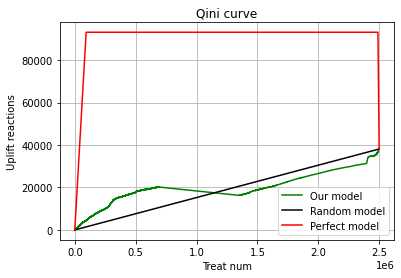

In [ ]:
X_test_1 = torch.FloatTensor(X_test_1)
X_test_0 = torch.FloatTensor(X_test_0)

model.eval()

mu_1 = model(X_test_1)
mu_0 = model(X_test_0)

pred = mu_1-mu_0

# print(pred)

# print(torch.min(pred))

pred = pred.detach().numpy()

# print(pred)
# print(y_test)

pred = pred.reshape((-1,)) 
# print(pred)
  
# pred = pd.Series(pred, index = y_test.index)

print("qini_auc_score",qini_auc_score(y_test, pred, treatment_test))


print("uplift_at_30%",uplift_at_k(y_test, pred, treatment_test))
# print(y_train[0:10])
# print("------------------")
# print(treatment_train[0:10])



plot_qini_curve(y_test, pred, treatment_test)


6912405.144559544 alpha = 0.2

alpha = 0.0  0

alpha = 0.1 663*10^4   0.048

alpha = 0.2   760*10^4

alpha = 0.3    804*10^4   0.053

alpha = 0.4   605*10^4  0.049

alpha = 0.5   688*10^4 0.054

alpha = 0.6   635*10^4 0.047

alpha = 0.7  728*10^4  0.057

alpha = 0.8  379*10^4 0.051

alpha = 0.9 365*10^4 0.044

alpha = 1.0 145*10^4  0.042


In [ ]:
import matplotlib.pyplot as plt


plt.plot(['0.0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1.0'], [0, 663, 760, 804, 605,688,635,728,379,365,145])
plt.title('Сравнение вкладов каждого из лосс')
plt.xlabel('alpha')
plt.ylabel('площадь под qini кривой (auqc)')

plt.show()

In [ ]:
X_train_1 = torch.FloatTensor(X_train_1)
X_train_0 = torch.FloatTensor(X_train_0)





model.eval()

mu_1 = model(X_train_1)
mu_0 = model(X_train_0)

pred = mu_1-mu_0

print(pred)

pred = pred.detach().numpy()
print(qini_auc_score(y_train, pred, treatment_train))

# print(y_train[0:10])
# print("------------------")
# print(treatment_train[0:10])
# plot_qini_curve(y_train, pred, treatment_train)

# tm_uplift_at_k = uplift_at_k(y_true=y_train, uplift=pred, treatment=treatment_train,
#                              strategy='overall', k=0.3)

print(tm_uplift_at_k)

# print(torch.max(pred))

proposing network with sigmoid





In [ ]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import random
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from statistics import mean

batch_size = 35006   # Number of samples in each batch
epoch_num = 40   # Number of epochs to train the network
lr = 0.0001        # Learning rate





class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(334, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        m = nn.Sigmoid()
        return m(x)
        

model = Model()
alpha = 0.8

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)
# model.to(device)
# print(model)


# #convert to torch structure
# X_test_1_tensor = torch.FloatTensor(X_test_1) 
# X_test_0_tensor = torch.FloatTensor(X_test_0)


# #convert to torch structure
# treatment_test = treatment_test.to_numpy()
# treatment_test = torch.from_numpy(treatment_test).int()
# treatment_test = Variable(treatment_test)


# #convert to torch structure
# y_test = y_test.to_numpy()
# y_test = torch.from_numpy(y_test).float()
# y_test  = Variable(y_test)


# #convert to torch structure
# Z_trans_test = Z_trans_test.to_numpy()
# Z_trans_test = torch.from_numpy(Z_trans_test).float()
# Z_trans_test = Variable(Z_trans_test)


#init loaders
# train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(dataset=test_data, batch_size=1)


# calculate the number of batches per epoch
batch_per_ep = X_train.shape[0] // batch_size

# define the loss (criterion) and create an optimizer
optimizer = optim.Adam(model.parameters())

# define lists of losses to store
all_losses  = []
test_losses = []
min_losses = []


model.train()
# epochs loop
for ep in range(epoch_num):  
    print(".......................... epoch =",ep,"..........................")
    i = 0
    # batches loop
    for batch_n in range(batch_per_ep):  
        batch_loss = []
       
        
        batch_1_feat = torch.FloatTensor(X_train_1[i:i+batch_size])
        batch_0_feat = torch.FloatTensor(X_train_0[i:i+batch_size])
        
        batch_label = y_train[i:i+batch_size]
        batch_Z_trans = Z_trans_train[i:i+batch_size]

        optimizer.zero_grad()
        # Forward pass (predict)
        mu_1_target_class = model(batch_1_feat)
        mu_0_target_class = model(batch_0_feat)

        #convert to torch structure
        treatment_batch = treatment_train[i:i+batch_size]
        treatment_batch = treatment_batch.to_numpy()
        treatment_batch = torch.from_numpy(treatment_batch).int()
        treatment_batch = Variable(treatment_batch)

        mu_0_target_class = torch.reshape(mu_0_target_class, shape = (-1,))
        mu_1_target_class = torch.reshape(mu_1_target_class, shape =(-1,) )
        
        # print("mu_0", mu_0_target_class)
        # print("mu_1", mu_1_target_class)

        ones = np.ones(shape = batch_size)
        ones = torch.from_numpy(ones).float()
        

       
        #implements mu = T * mu_1 + (1-T) * mu_0
        uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 

        

        
        #convert to torch structure
        batch_label = batch_label.to_numpy()
        batch_label = torch.from_numpy(batch_label).float()
        batch_label = Variable(batch_label)

       
        #convert to torch structure
        batch_Z_trans = batch_Z_trans.to_numpy()
        batch_Z_trans = torch.from_numpy(batch_Z_trans).float()
        batch_Z_trans = Variable(batch_Z_trans)
        batch_Z_trans = torch.reshape(batch_Z_trans, shape = (-1,))
        
        #declare losses
        loss_cross = nn.BCELoss(reduction = 'mean')
        loss_MSE = nn.MSELoss()

        #implements uplift_predicted = mu_1 - mu_0
        uplift_pred = mu_1_target_class - mu_0_target_class 
        
        
        # print("uplift_pred", uplift_pred)

        

        

        sum_of_losses = torch.mean(  (1-alpha) * loss_MSE(batch_Z_trans, uplift_pred) + alpha * loss_cross( uplift_pred_Y, batch_label))
        # print(loss_contrastive)
        batch_loss.append(sum_of_losses)
        # print("train AUQC:", qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))

        
        # print(batch_n, loss_contrastive)


        # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
        # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
        
        # Backward pass and updates
        sum_of_losses.backward()                     # calculate the gradients
        optimizer.step()                    # update the weights
        i += batch_size
        #end for !!!!!!!!!!!!!!!!!!!

    # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
    print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
    batch_loss  = list(batch_loss)
    all_losses.append( sum(batch_loss) / len(batch_loss) ) 

    # #work with test dataset

    # mu_1 = model(X_test_1_tensor)
    # mu_0 = model(X_test_0_tensor)

    # mu_1_target_class = mu_1
    # mu_0_target_class = mu_0

    # ones = np.ones(shape = X_test_1.shape[0])
    # ones = torch.from_numpy(ones).float()

    # #implements mu = T * mu_1 + (1-T) * mu_0
    # uplift_pred_Y = treatment_test * mu_1_target_class + (ones - treatment_test) * mu_0_target_class 

    # mu_0_target_class = torch.reshape(mu_0_target_class, (-1,))
    # mu_1_target_class = torch.reshape(mu_1_target_class, (-1,))
    

    
   
    
    # #declare losses
    # loss_cross = nn.BCELoss(reduction = 'mean')
    # loss_MSE = nn.MSELoss()

    # #implements uplift_predicted = mu_1 - mu_0
    # uplift_pred = mu_1_target_class - mu_0_target_class 

    # sum_of_losses =torch.mean(  (1-alpha) * loss_MSE(Z_trans_test, uplift_pred) + alpha * loss_cross( uplift_pred_Y, y_test) )
    # test_losses.append(sum_of_losses)

import matplotlib.pyplot as plt

plt.plot(all_losses, color='green')
plt.title('sum_of_losses')
plt.show()

# plt.plot(test_losses, color='blue')
# plt.title('sum_of_losses')
# plt.show()





In [ ]:
X_train_1 = torch.FloatTensor(X_train_1)
X_train_0 = torch.FloatTensor(X_train_0)



model.eval()

mu_1 = model(X_train_1)
mu_0 = model(X_train_0)

pred = mu_1-mu_0
print(qini_auc_score(y_train, pred.detach().numpy(), treatment_train))

print(pred)
print(torch.max(pred))

example of siamese network!!!!
 

In [ ]:
from __future__ import print_function
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import random
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from statistics import mean

batch_size = 55   # Number of samples in each batch
epoch_num = 12      # Number of epochs to train the network
lr = 0.001        # Learning rate
import torch.nn.functional as F




class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(334, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.exp(F.log_softmax(x,dim=1))    # F.log_softmax = log( exp(x_i) / exp(x).sum() )
        #return x



model = Model()
alpha = 0.9


# calculate the number of batches per epoch
batch_per_ep = X_train.shape[0] // batch_size

# define the loss (criterion) and create an optimizer
optimizer = optim.SGD(model.parameters(), lr=lr)

X_test_1_tensor = torch.FloatTensor(X_test_1)
X_test_0_tensor = torch.FloatTensor(X_test_0)

treatment_test = treatment_test.to_numpy()
treatment_test = torch.from_numpy(treatment_test).int()
treatment_test = Variable(treatment_test)

y_test = y_test.to_numpy()
y_test = torch.from_numpy(y_test ).float()
y_test  = Variable(y_test )


#convert to torch structure
Z_trans_test = Z_trans_test.to_numpy()
Z_trans_test = torch.from_numpy(Z_trans_test).float()
Z_trans_test = Variable(Z_trans_test)

Z_trans_test = torch.reshape(Z_trans_test, (X_test_1.shape[0],1))

all_losses  = []
test_losses = []
min_losses = []

for ep in range(epoch_num):  # epochs loop
    print("..........................epoch =",ep,"..........................")
    i = 0
    for batch_n in range(batch_per_ep):  # batches loop
        batch_loss = []
       
        
        batch_1_feat = torch.FloatTensor(X_train_1[i:i+batch_size])
        batch_0_feat = torch.FloatTensor(X_train_0[i:i+batch_size])
        
        batch_label = y_train[i:i+batch_size]
        batch_Z_trans = Z_trans_train[i:i+batch_size]

        # Reset gradients
        # optimizer.zero_grad()

        # Forward pass
        mu_1 = model(batch_1_feat)
        mu_0 = model(batch_0_feat)

        mu_1_target_class = mu_1[:,1]
        mu_0_target_class = mu_0[:,1]

        treatment_batch = treatment_train[i:i+batch_size]
        treatment_batch = treatment_batch.to_numpy()
        treatment_batch = torch.from_numpy(treatment_batch).int()
        treatment_batch = Variable(treatment_batch)


        
        
        ones = np.ones(shape = batch_size)
        ones = torch.from_numpy(ones).float()
        #implements mu = T * mu_1 + (1-T) * mu_0
        uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 


        mu_0_target_class = torch.reshape(mu_0_target_class, (batch_size,1))
        mu_1_target_class = torch.reshape(mu_1_target_class, (batch_size,1))
        #convert to torch structure
        batch_label = batch_label.to_numpy()
        batch_label = torch.from_numpy(batch_label).float()
        batch_label = Variable(batch_label)

       
        #convert to torch structure
        batch_Z_trans = batch_Z_trans.to_numpy()
        batch_Z_trans = torch.from_numpy(batch_Z_trans).float()
        batch_Z_trans = Variable(batch_Z_trans)

        batch_Z_trans = torch.reshape(batch_Z_trans, (batch_size,1))
        
        #declare losses
        loss_cross = nn.BCELoss(reduction = 'sum')
        loss_MSE = nn.MSELoss()

        #implements uplift_predicted = mu_1 - mu_0
        uplift_pred = mu_1_target_class - mu_0_target_class 
        

        
        loss_contrastive = torch.mean(  (1-alpha) * loss_MSE(batch_Z_trans, uplift_pred) + alpha * loss_cross( uplift_pred_Y, batch_label))
        
        batch_loss.append(loss_contrastive)
        

        
        # print(batch_n, loss_contrastive)


        optimizer.zero_grad()
        # Backward pass and updates
        loss_contrastive.backward()                     # calculate the gradients
        optimizer.step()                    # update the weights
        i += batch_size
        #end for!!!!!!!!!!!!!!!!!!!

    batch_loss  = list(batch_loss)
    all_losses.append( sum(batch_loss) / len(batch_loss)) 
    #work with test dataset

    mu_1 = model(X_test_1_tensor)
    mu_0 = model(X_test_0_tensor)

    mu_1_target_class = mu_1[:,1]
    mu_0_target_class = mu_0[:,1]

    ones = np.ones(shape = X_test_1.shape[0])
    ones = torch.from_numpy(ones).float()

    #implements mu = T * mu_1 + (1-T) * mu_0
    uplift_pred_Y = treatment_test * mu_1_target_class + (ones - treatment_test) * mu_0_target_class 

    mu_0_target_class = torch.reshape(mu_0_target_class, (X_test_1.shape[0],1))
    mu_1_target_class = torch.reshape(mu_1_target_class, (X_test_1.shape[0],1))
    

    
   
    
    #declare losses
    loss_cross = nn.BCELoss(reduction = 'sum')
    loss_MSE = nn.MSELoss()

    #implements uplift_predicted = mu_1 - mu_0
    uplift_pred = mu_1_target_class - mu_0_target_class 

    loss_contrastive =torch.mean(  (1-alpha) * loss_MSE(Z_trans_test, uplift_pred) + alpha * loss_cross( uplift_pred_Y, y_test))
    test_losses.append(loss_contrastive)
    
    # print(qini_auc_score(y_test.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_test.cpu().detach().numpy() ))

import matplotlib.pyplot as plt
plt.plot(all_losses,color='blue')
# plt.plot(test_losses, color='green')
plt.title('Contrastive Loss')
plt.show()

plt.plot(all_losses,color='blue')
plt.show()

In [ ]:
from __future__ import print_function
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import random
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from statistics import mean

batch_size = 55   # Number of samples in each batch
epoch_num = 20      # Number of epochs to train the network
lr = 0.001        # Learning rate
import torch.nn.functional as F




class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(334, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.exp(F.log_softmax(x,dim=1))
        #return x



model = Model()
alpha = 0.8


# calculate the number of batches per epoch
batch_per_ep = X_train.shape[0] // batch_size

# define the loss (criterion) and create an optimizer
optimizer = optim.SGD(model.parameters(), lr=lr)







Z_trans_test = torch.reshape(Z_trans_test, (X_test_1.shape[0],1))
all_losses  = []
min_losses =[]
for ep in range(epoch_num):  # epochs loop
    print("..........................epoch =",ep,"..........................")
    i = 0
    for batch_n in range(batch_per_ep):  # batches loop
        batch_loss = []
       
        
        batch_1_feat = torch.FloatTensor(X_train_1[i:i+batch_size])
        batch_0_feat = torch.FloatTensor(X_train_0[i:i+batch_size])
        
        batch_label = y_train[i:i+batch_size]
        batch_Z_trans = Z_trans[i:i+batch_size]

        # Reset gradients
        # optimizer.zero_grad()

        # Forward pass
        mu_1 = model(batch_1_feat)
        mu_0 = model(batch_0_feat)

        mu_1_target_class = mu_1[:,1]
        mu_0_target_class = mu_0[:,1]

        treatment_batch = treatment_train[i:i+batch_size]
        treatment_batch = torch.from_numpy(treatment_batch).int()
        treatment_batch = Variable(treatment_batch)


        
        
        ones = np.ones(shape = batch_size)
        ones = torch.from_numpy(ones).float()
        #implements mu = T * mu_1 + (1-T) * mu_0
        uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 


        mu_0_target_class = torch.reshape(mu_0_target_class, (batch_size,1))
        mu_1_target_class = torch.reshape(mu_1_target_class, (batch_size,1))
        #convert to torch structure
        batch_label = torch.from_numpy(batch_label).float()
        batch_label = Variable(batch_label)

       
        #convert to torch structure
        batch_Z_trans = batch_Z_trans.to_numpy()
        batch_Z_trans = torch.from_numpy(batch_Z_trans).float()
        batch_Z_trans = Variable(batch_Z_trans)

        batch_Z_trans = torch.reshape(batch_Z_trans, (batch_size,1))
        
        #declare losses
        loss_cross = nn.BCELoss(reduction = 'sum')
        loss_MSE = nn.MSELoss()

        #implements uplift_predicted = mu_1 - mu_0
        uplift_pred = mu_1_target_class - mu_0_target_class 

        loss_contrastive =torch.mean(  (1-alpha) * loss_MSE(batch_Z_trans, uplift_pred) + alpha * loss_cross( uplift_pred_Y, batch_label))

        batch_loss.append(loss_contrastive)
        
        # print(batch_n, loss_contrastive)


        optimizer.zero_grad()
        # Backward pass and updates
        loss_contrastive.backward()                     # calculate the gradients
        optimizer.step()                    # update the weights
        i += batch_size
    batch_loss  = list(batch_loss)
    all_losses.append( sum(batch_loss) / len(batch_loss)) 

import matplotlib.pyplot as plt
plt.plot(all_losses)
plt.title('Contrastive Loss')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(all_losses[:210000])
plt.title('Contrastive Loss')
plt.show()